# Implémentation d'un modèle de scoring

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from os import listdir 
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from sklearn.preprocessing import MinMaxScaler

# les observations dans chaque catégorie
def categ_plot(frame, hue=None):
    """les observations dans chaque catégorie """
    if hue is not None:
        hue = hue
        
    df = frame.dtypes
    df.index.name = 'columns'
    df = pd.DataFrame(df, columns=['dtype'])
    df = df.reset_index()
    df = df[df['dtype'] == 'object']
    list_objects = df['columns'].tolist()
    
    for obj in list_objects:
        plt.figure(figsize=(16,5))
        plot = sns.countplot(obj, data=frame, hue=hue)
        plt.xticks(rotation=90)

################################################################

def var_plot(frame, hue=None, vartypes="float64", kind="kde"):
    """Répartition empirique des variables numériques """
    if hue is not None:
        hue = hue
        
    df = frame.dtypes
    df.index.name = 'columns'
    df = pd.DataFrame(df, columns=['dtype'])
    df = df.reset_index()
    df = df[df['dtype'] == vartypes]
    list_objects = df['columns'].tolist()
    
    for obj in list_objects:
        plt.figure(figsize=(16,5))
        plot = sns.displot(frame, x=obj, hue=hue, kind=kind)#, multiple="stack"
        plt.xticks(rotation=90)
#############################################################
## Taux de remplissage des colonnes
def col_filling(data, head=60):
    """ Taux de remplissage des colonnes """
    print((data.isnull().sum()/data.shape[0]).sort_values(ascending=False).head(head))
    data_describe = data.describe(include='all')
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 5))
    plt.title('Remplissage des colonnes', size=10)
    plot = sns.barplot(x=data_describe.columns, y=data_describe.iloc[0,])
    plt.xticks(rotation=90)
    plt.show()
#############################################################
def get_NaN_col(data, limit=0.30):
    """ obtenir les variables qui ont un taux ne NaN supérieur à limit """
    drop_list = []
    for key, value in dict((data.isnull().sum()/data.shape[0])).items():
      if value > limit:
        col = key
        drop_list.append(col)
    return drop_list

###########################################################
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

###########################################################



############################################################################
def my_cost_func(y_test, y_pred):

    ''' 
    Customer cost function 
    '''
    cm = confusion_matrix(y_test, y_pred)
    score=(((10*cm[1,0]) + cm[0, 1])/cm.sum())
    return score

#######################################################################
def print_score(classifier, X_train, y_train, X_test, y_test, train=True):
    '''
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    if train:
        '''
        training performance
        '''
        print("Train Result:\n")
        #print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, classifier.predict(X_train)))) ##taux de bon classement 
        print("roc_auc_score: {0:.4f}\n".format(roc_auc_score(y_train, classifier.predict(X_train)))) ## score de roc 
        print("classification_report: \n {}\n".format(classification_report(y_train, classifier.predict(X_train)))) ## matrice de confusion
        print("Cost function: \n {}\n".format(my_cost_func(y_train, classifier.predict(X_train))))
        ### evaluation des métriques par validation croisée 
        res = cross_val_score(classifier, X_train, y_train, cv=5, scoring='accuracy') ### estimation du taux de bon classement par validation croisée        
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res))) 
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res))) 
        
    elif train==False:
        '''
        test performance
        '''
        print("Test Result:\n")        
        #print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, classifier.predict(X_test))))
        print("roc_auc_score: {0:.4f}\n".format(roc_auc_score(y_test, classifier.predict(X_test)))) ## score de roc 
        print("classification_report: \n {}\n".format(classification_report(y_test, classifier.predict(X_test))))
        print("Cost function: \n {}\n".format(my_cost_func(y_test, classifier.predict(X_test))))

#######################################################################################
# Display/plot feature importance
def display_importances(model, feats, name='Model_features_importance'):
    '''
    feature importance plot
    
    '''
    feature_importance_df_ = pd.DataFrame()
    # get importance
    feature_importance_df_["feature"] = feats
    feature_importance_df_["importance"] = model.feature_importances_
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title(name)
    plt.tight_layout()
    plt.savefig(name+'.png')
#####################################################################################
def top_model(stand = MinMaxScaler()):
    
    pipeline1 = Pipeline([
                     ('normalizer', stand), #Step1 - normalize data
                     ('clf', LogisticRegression(penalty='l2',  solver='newton-cg', random_state=121)) #step2 - classifier
                     ])
    
    pipeline2 = Pipeline([
                     ('normalizer', stand), #Step1 - normalize data
                     ('clf', RandomForestClassifier(n_estimators= 500, bootstrap=True, criterion = 'entropy', max_depth=3, random_state=121)) #step2 - classifier
                     ])
    
    pipeline3 = Pipeline([
                     ('normalizer', stand), #Step1 - normalize data
                     ('clf', LGBMClassifier(n_estimators=1000 ,max_depth = 30, random_state=121)) #step2 - classifier
                     ])
    accur1 = cross_val_score(pipeline1, data_smt.drop(['TARGET'], axis=1), data_smt['TARGET'], cv=5, scoring='accuracy') ##taux de bon classement 
    maccur1 = np.mean(accur1)
    roc_auc1 = cross_val_score(pipeline1, data_smt.drop(['TARGET'], axis=1), data_smt['TARGET'], cv=5, scoring='roc_auc') ## score de roc 
    mroc_auc1 = np.mean(roc_auc1)
    f1 = cross_val_score(pipeline1, data_smt.drop(['TARGET'], axis=1), data_smt['TARGET'], cv=5, scoring='f1')
    mf1 = np.mean(f1)
    cost_fun1 =cross_val_score(pipeline1, X_train, y_train, cv=5,scoring= custom_score)
    mcost_fun1 = np.mean(cost_fun1)

    accur2 = cross_val_score(pipeline2, data_smt.drop(['TARGET'], axis=1), data_smt['TARGET'], cv=5, scoring='accuracy') ##taux de bon classement 
    maccur2 = np.mean(accur2)
    roc_auc2 = cross_val_score(pipeline2, data_smt.drop(['TARGET'], axis=1), data_smt['TARGET'], cv=5, scoring='roc_auc') ## score de roc 
    mroc_auc2 = np.mean(roc_auc2)
    f2 = cross_val_score(pipeline2, data_smt.drop(['TARGET'], axis=1), data_smt['TARGET'], cv=5, scoring='f1')
    mf2 = np.mean(f2)
    cost_fun2 =cross_val_score(pipeline2, X_train, y_train, cv=5,scoring= custom_score)
    mcost_fun2 = np.mean(cost_fun2)

    accur3 = cross_val_score(pipeline3, data_smt.drop(['TARGET'], axis=1), data_smt['TARGET'], cv=5, scoring='accuracy') ##taux de bon classement 
    maccur3 = np.mean(accur3)
    roc_auc3 = cross_val_score(pipeline3, data_smt.drop(['TARGET'], axis=1), data_smt['TARGET'], cv=5, scoring='roc_auc') ## score de roc 
    mroc_auc3 = np.mean(roc_auc3)
    f3 = cross_val_score(pipeline3, data_smt.drop(['TARGET'], axis=1), data_smt['TARGET'], cv=5, scoring='f1')
    mf3 = np.mean(f3)
    cost_fun3 =cross_val_score(pipeline3, X_train, y_train, cv=5,scoring= custom_score)
    mcost_fun3 = np.mean(cost_fun3)

    tab_app = pd.DataFrame(data = [[maccur1, mroc_auc1, mf1, mcost_fun1],[maccur2, mroc_auc2, mf2, mcost_fun2],[maccur3, mroc_auc3, mf3, mcost_fun3]],
                                       columns = ['Accuracy score','Roc auc score', 'f1_score', 'customer function'], index = ['Logistic Regression','Random Forest Classifier','LGBM Classifier']) 
    plt.figure(figsize=(12,3))
    g = sns.heatmap(tab_app,linewidths=.2, cmap="YlGnBu", annot=True, fmt=".3f")
    g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
    g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 12)
    plt.title("Models Performance")
    plt.show()
    return tab_app 
##################################################################################
# construire la courbe ROC
def build_ROC(y_test, y_predict, export_name='', title='ROC Curve'):
    fpr, tpr, thr = roc_curve(y_test, y_predict)
    auc = auc(fpr, tpr)
    fig = plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, '-', lw=2, label='gamma=0.01, AUC=%.2f' % auc)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title(title, fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.savefig(path+export_name+'ROC.png', bbox_inches='tight')
    plt.show()
    
############################################################################
def top_model2(model1, model2, model3, X_train, y_train, X_test, y_test, train=True):
    '''
    train performance
    '''
    if train:
        accur1 = accuracy_score(y_train, model1.predict(X_train)) ##taux de bon classement 
        roc_auc1 = roc_auc_score(y_train, model1.predict(X_train)) ## score de roc 
        cost_fun1 =my_cost_func(y_train, model1.predict(X_train))

        accur2 = accuracy_score(y_train, model2.predict(X_train)) ##taux de bon classement 
        roc_auc2 = roc_auc_score(y_train, model2.predict(X_train)) ## score de roc 
        cost_fun2 =my_cost_func(y_train, model2.predict(X_train))

        accur3 = accuracy_score(y_train, model3.predict(X_train)) ##taux de bon classement 
        roc_auc3 = roc_auc_score(y_train, model3.predict(X_train)) ## score de roc 
        cost_fun3 =my_cost_func(y_train, model3.predict(X_train))

        tab_app = pd.DataFrame(data = [[accur1, roc_auc1, cost_fun1],[accur2, roc_auc2, cost_fun2],[accur3, roc_auc3, cost_fun3]],
                                       columns = ['Accuracy score','Roc auc score','customer function'], index = ['Logistic Regression','Random Forest Classifier','LGBM Classifier']) 
    elif train==False:
        '''
        test performance
        '''
        accur1 = accuracy_score(y_test, model1.predict(X_test)) ##taux de bon classement 
        roc_auc1 = roc_auc_score(y_test, model1.predict(X_test)) ## score de roc 
        cost_fun1 =my_cost_func(y_test, model1.predict(X_test))

        accur2 = accuracy_score(y_test, model2.predict(X_test)) ##taux de bon classement 
        roc_auc2 = roc_auc_score(y_test, model2.predict(X_test)) ## score de roc 
        cost_fun2 =my_cost_func(y_test, model2.predict(X_test))

        accur3 = accuracy_score(y_test, model3.predict(X_test)) ##taux de bon classement 
        roc_auc3 = roc_auc_score(y_test, model3.predict(X_test)) ## score de roc 
        cost_fun3 =my_cost_func(y_test, model3.predict(X_test))

        tab_app = pd.DataFrame(data = [[accur1, roc_auc1, cost_fun1],[accur2, roc_auc2, cost_fun2],[accur3, roc_auc3, cost_fun3]],
                                       columns = ['Accuracy score','Roc auc score','customer function'], index = ['Logistic Regression','Random Forest Classifier','LGBM Classifier']) 
    
    plt.figure(figsize=(12,3))
    g = sns.heatmap(tab_app,linewidths=.2, cmap="YlGnBu", annot=True, fmt=".3f")
    g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
    g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 12)
    plt.title("Models Performance")
    plt.show()
##############################################################################


- ## Exploration des données

In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/P7_Implémentation_Modele_scoring/Projet7/'

In [ ]:
## Echantillon de données d'apprentissage des demandes de prêt. 
# Une ligne représente un prêt dans notre échantillon de données
application_train = pd.read_csv(path+'application_train.csv')

## Echantillon de données de test des demandes de prêt. 
# Une ligne représente un prêt dans notre échantillon de données
application_test = pd.read_csv(path+'application_test.csv')

# Tous les crédits précédents du client fournis par d'autres institutions 
# financières qui ont été rapportés au Bureau de Credit (pour les clients qui ont un prêt dans notre échantillon).
# Pour chaque prêt de nos échantillons d'apprentissage et de test, il y a autant de 
# lignes que de crédits que le client avait dans le Credit Bureau avant la date de la demande.
bureau = pd.read_csv(path+'bureau.csv')

# Soldes mensuels des crédits précédents dans le Credit Bureau.
# Ce tableau a une ligne pour chaque mois de l'historique de chaque crédit précédent rapporté au Credit Bureau.
# - c'est à dire que le tableau a (# de prêts dans l'échantillon * # de crédits précédents 
# relatifs * # de mois où nous avons un historique observable pour les crédits précédents) lignes
bureau_balance = pd.read_csv(path+'bureau_balance.csv')

# Toutes les demandes précédentes de prêts pour le crédit immobilier des clients qui ont des prêts dans notre échantillon.
# Il y a une ligne pour chaque demande antérieure liée aux prêts dans notre échantillon de données.
previous_application = pd.read_csv(path+'previous_application.csv')

# Instantanés des soldes mensuels des cartes de crédit précédentes que le demandeur possède chez Home Credit.
# Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit précédent 
# dans le Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon
# - c'est-à-dire que le tableau comporte (#prêts dans l'échantillon * # de cartes de crédit précédentes 
# relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes
credit_card_balance = pd.read_csv(path+'credit_card_balance.csv')

# Instantanés des soldes mensuels des prêts POS (point of sales) et cash précédents que le demandeur a eu avec Home Credit.
# Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit précédent 
# au Home Credit (crédit à la consommation et prêts au comptant) lié aux prêts de notre échantillon
# - c'est-à-dire que le tableau comporte (# de prêts dans l'échantillon * # de crédits précédents 
# relatifs * # de mois dans lesquels nous avons un historique observable pour les crédits précédents) lignes.
POS_CASH_balance = pd.read_csv(path+'POS_CASH_balance.csv')

# Historique des remboursements pour les crédits précédemment déboursés dans Home Credit liés aux prêts de notre échantillon.
# Il y a a) une ligne pour chaque paiement qui a été effectué plus b) une ligne pour chaque paiement manqué.
# Une ligne équivaut à un paiement d'un versement OU à un versement correspondant à un paiement 
# d'un crédit précédent de Home Credit lié aux prêts de notre échantillon.
installments_payments = pd.read_csv(path+'installments_payments.csv')

# Ce fichier contient les descriptions des colonnes des différents fichiers de données.
#HomeCredit_columns_description = pd.read_csv(path+'HomeCredit_columns_description.csv')

sample_submission = pd.read_csv(path+'sample_submission.csv')


In [ ]:
HomeCredit_columns_description = pd.read_csv(path+'HomeCredit_columns_description.csv',  index_col=0, encoding= 'unicode_escape')#, usecols=['Row', 'Description']

In [ ]:
HomeCredit_columns_description

,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...
217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


- application_train (chantillon de données d'apprentissage des demandes de prêt)
- Nous allons utiliser ce dataset pour la modélisation du score

In [ ]:
print("Dimension des données d'entrainement:",application_train.shape)
print(application_train.dtypes.value_counts())

Dimension des données d'entrainement: (307511, 122)
float64    65
int64      41
object     16
dtype: int64


1. Cet ensemble de données se compose de **307511 lignes** et **122 colonnes**.
2. Chaque ligne a un identifiant unique « **SK_ID_CURR** » et l'étiquette de sortie se trouve dans la colonne `TARGET`.
3. **`TARGET`** indiquant 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé.
4. La description de chaque colonne se trouve dans le fichier **`HomeCredit_columns_description.csv`**

In [ ]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
application_train['AMT_REQ_CREDIT_BUREAU_YEAR'].min()

0.0

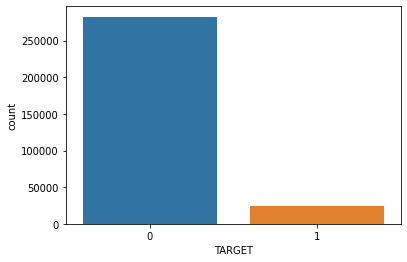

In [ ]:
# distribution de la variable cible
sns.countplot(x=application_train['TARGET'])

In [ ]:
application_train['TARGET'].value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

- La proportion des demandes acceptées est beaucoup plus importante (92%) dans l'échantillon d'entrainement par rapport à celles refusées. L'échantillon des données est deséquilibré.

In [ ]:
application_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

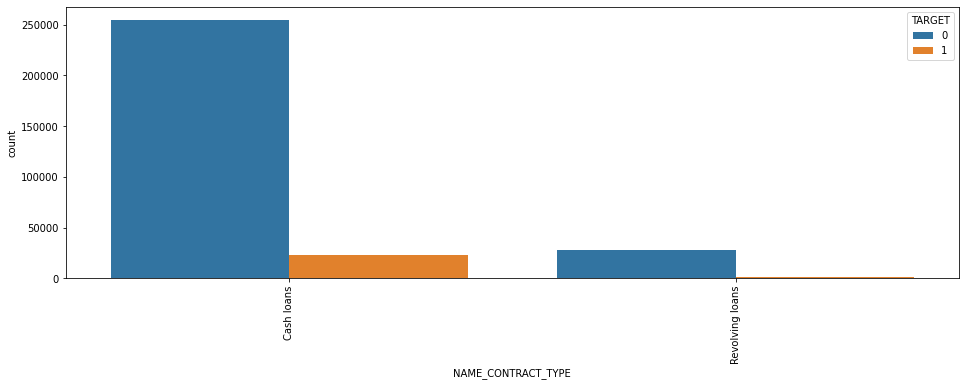

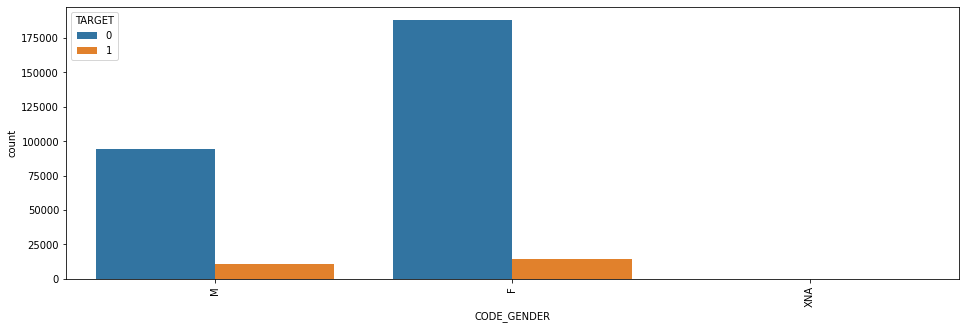

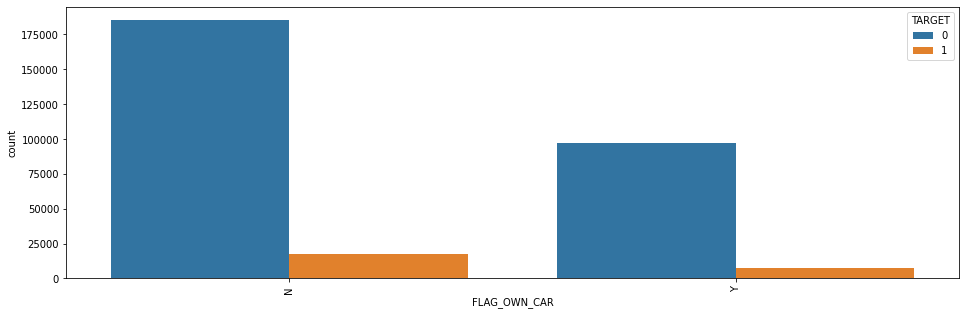

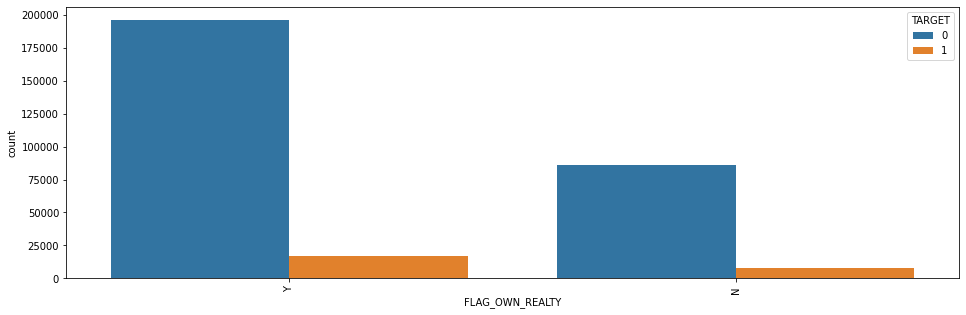

In [ ]:
# les observations dans chaque catégorie
categ_plot(application_train[['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER','FLAG_OWN_CAR', 
                              'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                              'AMT_CREDIT', 'AMT_ANNUITY']], hue='TARGET')

- Nous avons deux type de contrat, prêt en cash et un prêt renouvellable. Pour tous les types de contrat la proportion des clients sans diffuclté de paiement est supérieure à celle avec difficultés de paiement.
- La proportion de femmes dans l'échantillon est supérieure à celle des hommes. Nous constatons une catégorie de genre inconnu que nous allons supprimer.

In [ ]:
#print("Description",HomeCredit_columns_description[HomeCredit_columns_description['Row']=="CNT_FAM_MEMBERS"]["Description"])

Description 32    How many family members does client have
Name: Description, dtype: object


In [ ]:
print("Description",HomeCredit_columns_description[HomeCredit_columns_description['Row']=="NAME_CONTRACT_TYPE"]["Description"])
print(application_train['NAME_CONTRACT_TYPE'].value_counts(normalize=True))

Description 5            Identification if loan is cash or revolving
178    Contract product type (Cash loan, consumer loa...
Name: Description, dtype: object
Cash loans         0.904787
Revolving loans    0.095213
Name: NAME_CONTRACT_TYPE, dtype: float64


In [ ]:
application_train[application_train['TARGET']== 0]['NAME_CONTRACT_TYPE'].value_counts(normalize=True)

Cash loans         0.9021
Revolving loans    0.0979
Name: NAME_CONTRACT_TYPE, dtype: float64

In [ ]:
print("Description",HomeCredit_columns_description[HomeCredit_columns_description['Row']=="CODE_GENDER"]["Description"])
print(application_train['CODE_GENDER'].value_counts(normalize=True))

Description 6    Gender of the client
Name: Description, dtype: object
F      0.658344
M      0.341643
XNA    0.000013
Name: CODE_GENDER, dtype: float64


In [ ]:
application_train[application_train['TARGET']== 0]['CODE_GENDER'].value_counts(normalize=True)

F      0.666032
M      0.333954
XNA    0.000014
Name: CODE_GENDER, dtype: float64

In [ ]:
print("Description",HomeCredit_columns_description[HomeCredit_columns_description['Row']=="FLAG_OWN_CAR"]["Description"])
print(application_train['FLAG_OWN_CAR'].value_counts(normalize=True))

Description 7    Flag if the client owns a car
Name: Description, dtype: object
N    0.659892
Y    0.340108
Name: FLAG_OWN_CAR, dtype: float64


In [ ]:
application_train[application_train['TARGET']== 0]['FLAG_OWN_CAR'].value_counts(normalize=True)

N    0.656824
Y    0.343176
Name: FLAG_OWN_CAR, dtype: float64

In [ ]:
application_train['DAYS_REGISTRATION']

<Figure size 1152x360 with 0 Axes>

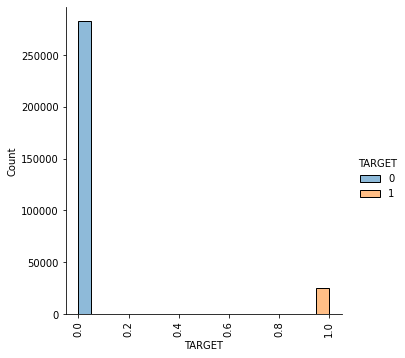

<Figure size 1152x360 with 0 Axes>

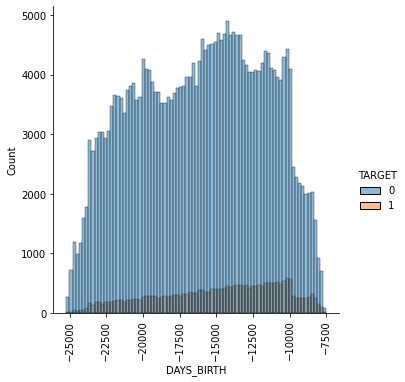

<Figure size 1152x360 with 0 Axes>

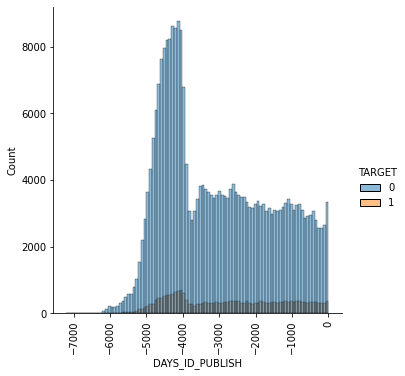

<Figure size 1152x360 with 0 Axes>

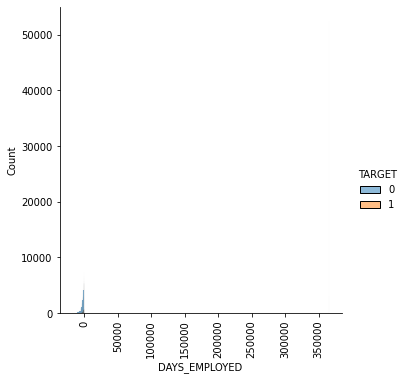

In [ ]:
# répartition des variables numériques
var_plot(application_train[['TARGET', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED' , 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION' ]], hue='TARGET', vartypes="int64", kind="hist")

In [ ]:
print("Description",HomeCredit_columns_description[HomeCredit_columns_description['Row']=="DAYS_BIRTH"]["Description"])
print("Age minimum", ((application_train['DAYS_BIRTH']/365)*(-1)).min())
print("Age maximum", ((application_train['DAYS_BIRTH']/365)*(-1)).max())

Description 20    Client's age in days at the time of application
Name: Description, dtype: object
Age minimum 20.517808219178082
Age maximum 69.12054794520547


<Figure size 1152x360 with 0 Axes>

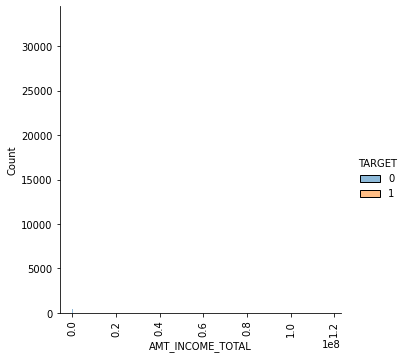

<Figure size 1152x360 with 0 Axes>

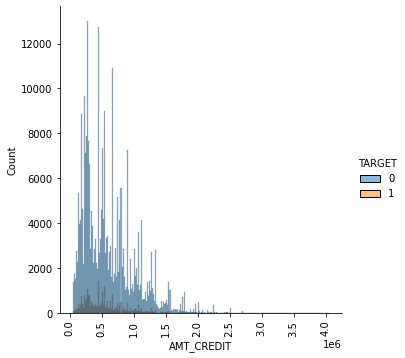

<Figure size 1152x360 with 0 Axes>

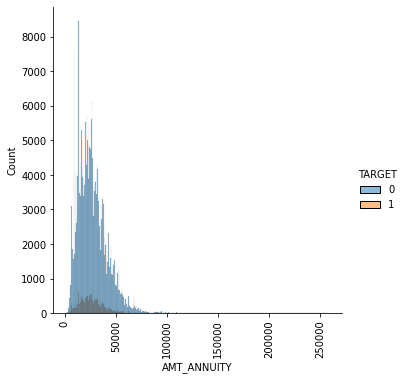

<Figure size 1152x360 with 0 Axes>

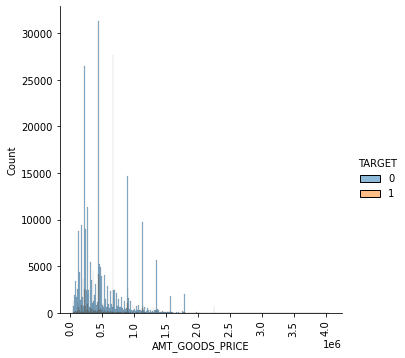

In [ ]:
# répartition des variables numériques
var_plot(application_train[['TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE' ]], hue='TARGET', vartypes="float64", kind="hist")#, kind="kde"

- ## Nettoyage des données

- Le traitement de nettoyage se fera seulement sur l'échantillon d'apprentissage puisque c'est ce dataset que nous utilisons pour notre modélisation.

COMMONAREA_MEDI                 0.698723
COMMONAREA_AVG                  0.698723
COMMONAREA_MODE                 0.698723
NONLIVINGAPARTMENTS_MODE        0.694330
NONLIVINGAPARTMENTS_AVG         0.694330
NONLIVINGAPARTMENTS_MEDI        0.694330
FONDKAPREMONT_MODE              0.683862
LIVINGAPARTMENTS_MODE           0.683550
LIVINGAPARTMENTS_AVG            0.683550
LIVINGAPARTMENTS_MEDI           0.683550
FLOORSMIN_AVG                   0.678486
FLOORSMIN_MODE                  0.678486
FLOORSMIN_MEDI                  0.678486
YEARS_BUILD_MEDI                0.664978
YEARS_BUILD_MODE                0.664978
YEARS_BUILD_AVG                 0.664978
OWN_CAR_AGE                     0.659908
LANDAREA_MEDI                   0.593767
LANDAREA_MODE                   0.593767
LANDAREA_AVG                    0.593767
BASEMENTAREA_MEDI               0.585160
BASEMENTAREA_AVG                0.585160
BASEMENTAREA_MODE               0.585160
EXT_SOURCE_1                    0.563811
NONLIVINGAREA_MO

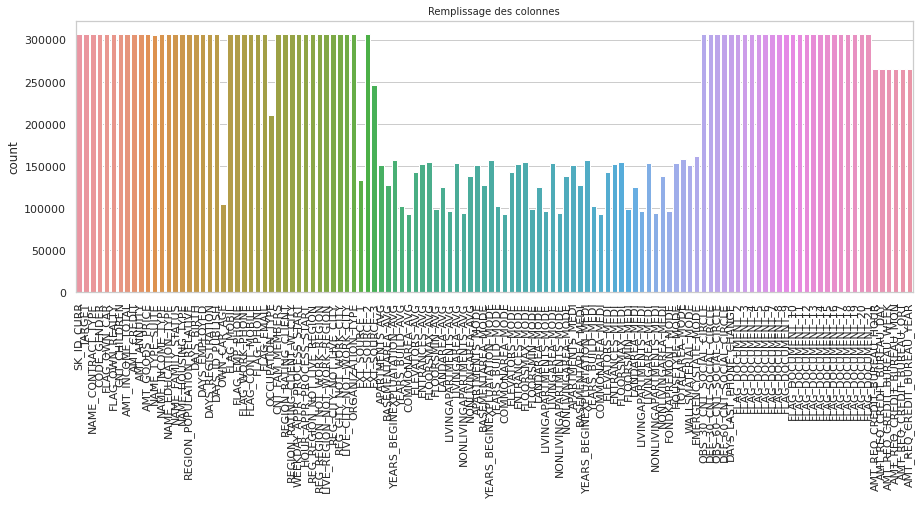

In [ ]:
## Détection des valeurs manquantes
col_filling(application_train, head=60)

In [ ]:
## détection et Suppression des variables contenant plus de 20% de valeurs manquantes
# traitement demanderait beaucoup de temps et aurait toujours un faible pouvoir explicatif.
application_train.shape
NaN_col = get_NaN_col(application_train, limit=0.20)
#NaN_col
data_work_train=application_train.drop(NaN_col, axis=1)
print('- Nombre de variables contenant plus de 20% de valeurs manquantes : ', (application_train.shape[1] - data_work_train.shape[1]))

- Nombre de variables contenant plus de 20% de valeurs manquantes :  50


In [ ]:
# détection des valeurs manquantes 
#col_filling(data_work_train, head=60)

In [ ]:
#NaN_col_to_imput = get_NaN_col(data_work_train, limit=0.0)
#print("Nombre de variables contenants moins de 20 % de valeurs manquantes :",'\n' ,' Types de variables :\n',  data_work_train[NaN_col_to_imput].dtypes.value_counts())
#print("la liste des variables contenant des données manquantes :\n ",NaN_col_to_imput)
#display(data_work_train[NaN_col_to_imput].head())

EXT_SOURCE_3                  0.198253
AMT_REQ_CREDIT_BUREAU_YEAR    0.135016
AMT_REQ_CREDIT_BUREAU_QRT     0.135016
AMT_REQ_CREDIT_BUREAU_MON     0.135016
AMT_REQ_CREDIT_BUREAU_WEEK    0.135016
AMT_REQ_CREDIT_BUREAU_DAY     0.135016
AMT_REQ_CREDIT_BUREAU_HOUR    0.135016
NAME_TYPE_SUITE               0.004201
DEF_60_CNT_SOCIAL_CIRCLE      0.003320
OBS_30_CNT_SOCIAL_CIRCLE      0.003320
DEF_30_CNT_SOCIAL_CIRCLE      0.003320
OBS_60_CNT_SOCIAL_CIRCLE      0.003320
EXT_SOURCE_2                  0.002146
AMT_GOODS_PRICE               0.000904
AMT_ANNUITY                   0.000039
CNT_FAM_MEMBERS               0.000007
DAYS_LAST_PHONE_CHANGE        0.000003
FLAG_DOCUMENT_18              0.000000
FLAG_DOCUMENT_5               0.000000
FLAG_DOCUMENT_21              0.000000
dtype: float64


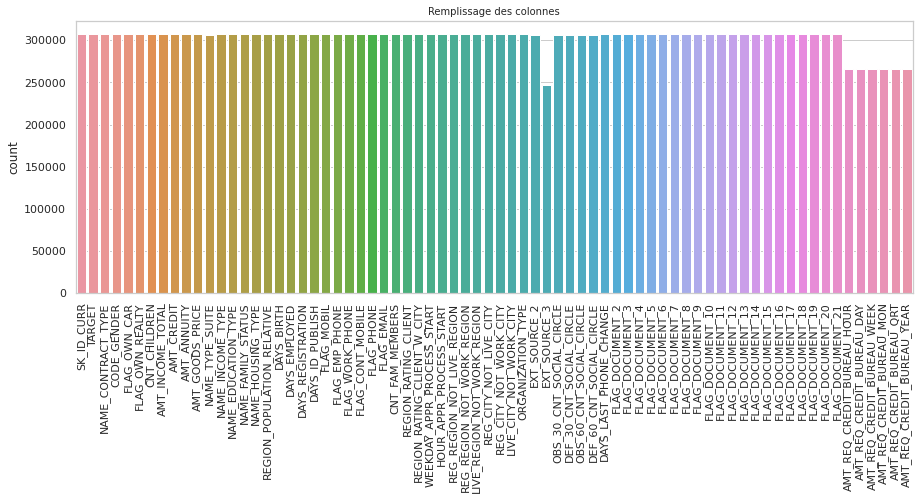

In [ ]:
## Détection des valeurs manquantes
col_filling(data_work_train, head=20)

- Nous avons 17 variables qui contiennent toujours des valeurs manquantes.

- ##### Détection des valeurs abbérantes

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


sort descending 29174     0.896010
189133    0.893976
180278    0.893976
91010     0.887664
142137    0.885488
Name: EXT_SOURCE_3, dtype: float64
sort ascending 12783     0.000527
130701    0.000527
130687    0.000527
271969    0.000527
129570    0.000527
Name: EXT_SOURCE_3, dtype: float64


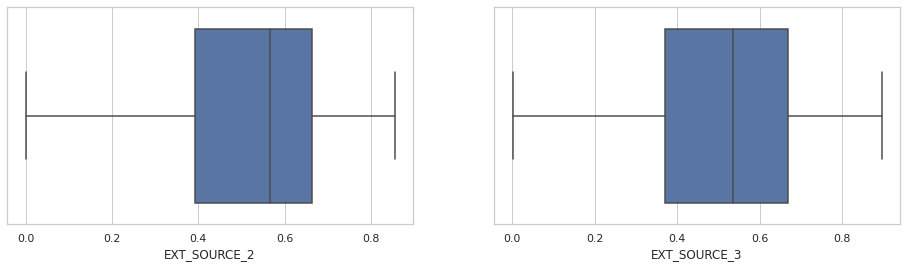

In [ ]:
### valeurs aberrantes des variables 
## affichage des boxplots
fig = plt.figure(figsize=(16,4))
plt.rcParams.update({'font.size': 6})
fig.add_subplot(1, 2, 1)
sns.boxplot(data_work_train["EXT_SOURCE_2"])
fig.add_subplot(1, 2, 2)
sns.boxplot(data_work_train["EXT_SOURCE_3"])
print('sort descending',data_work_train["EXT_SOURCE_3"].sort_values(ascending=False)[0:5])
print('sort ascending',data_work_train["EXT_SOURCE_3"].sort_values(ascending=True)[0:5])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


sort descending 19824     25.0
29612     23.0
76655     22.0
132792    21.0
278398    20.0
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: float64
sort ascending 62906     0.0
75186     0.0
199093    0.0
199094    0.0
199102    0.0
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: float64


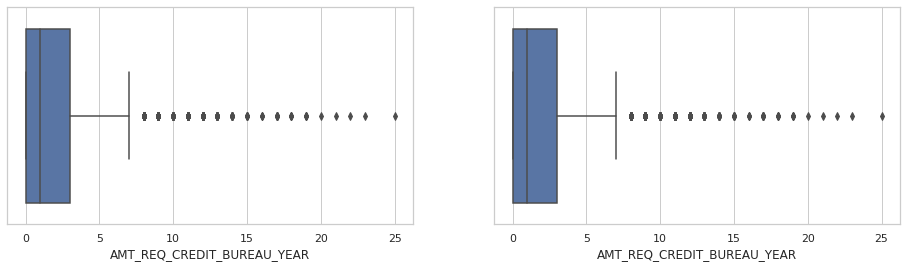

In [ ]:
### valeurs aberrantes des variables 
## affichage des boxplots
fig = plt.figure(figsize=(16,4))
plt.rcParams.update({'font.size': 6})
fig.add_subplot(1, 2, 1)
sns.boxplot(data_work_train["AMT_REQ_CREDIT_BUREAU_YEAR"])
fig.add_subplot(1, 2, 2)
sns.boxplot(data_work_train["AMT_REQ_CREDIT_BUREAU_YEAR"])
print('sort descending',data_work_train["AMT_REQ_CREDIT_BUREAU_YEAR"].sort_values(ascending=False)[0:5])
print('sort ascending',data_work_train["AMT_REQ_CREDIT_BUREAU_YEAR"].sort_values(ascending=True)[0:5])

- ##### Imputation des variables
- Nous allons faire une imputation par la moyenne des 16 variables numériques et une imputation par le mode de la variable catégorielle

In [ ]:
## valeurs par catégorie
print("=================== Avant imputation des valeurs manquantes =====================")
print(data_work_train['NAME_TYPE_SUITE'].value_counts(dropna=False))
print("=================== Après imputation des valeurs manquantes =====================")
## imputation de la variable catégorielle NAME_TYPE_SUITE
data_work_train['NAME_TYPE_SUITE'] = data_work_train['NAME_TYPE_SUITE'].fillna(data_work_train['NAME_TYPE_SUITE'].mode()[0])
print(data_work_train['NAME_TYPE_SUITE'].value_counts(dropna=False))

=================== Avant imputation des valeurs manquantes =====================
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
NaN                  1292
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64
=================== Après imputation des valeurs manquantes =====================
Unaccompanied      249818
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64


AMT_REQ_CREDIT_BUREAU_YEAR     0.0
AMT_REQ_CREDIT_BUREAU_QRT      0.0
DAYS_REGISTRATION              0.0
DAYS_ID_PUBLISH                0.0
FLAG_MOBIL                     0.0
FLAG_EMP_PHONE                 0.0
FLAG_WORK_PHONE                0.0
FLAG_CONT_MOBILE               0.0
FLAG_PHONE                     0.0
FLAG_EMAIL                     0.0
CNT_FAM_MEMBERS                0.0
REGION_RATING_CLIENT           0.0
REGION_RATING_CLIENT_W_CITY    0.0
WEEKDAY_APPR_PROCESS_START     0.0
HOUR_APPR_PROCESS_START        0.0
REG_REGION_NOT_LIVE_REGION     0.0
REG_REGION_NOT_WORK_REGION     0.0
DAYS_EMPLOYED                  0.0
DAYS_BIRTH                     0.0
REGION_POPULATION_RELATIVE     0.0
AMT_INCOME_TOTAL               0.0
TARGET                         0.0
NAME_CONTRACT_TYPE             0.0
CODE_GENDER                    0.0
FLAG_OWN_CAR                   0.0
FLAG_OWN_REALTY                0.0
CNT_CHILDREN                   0.0
AMT_CREDIT                     0.0
NAME_HOUSING_TYPE   

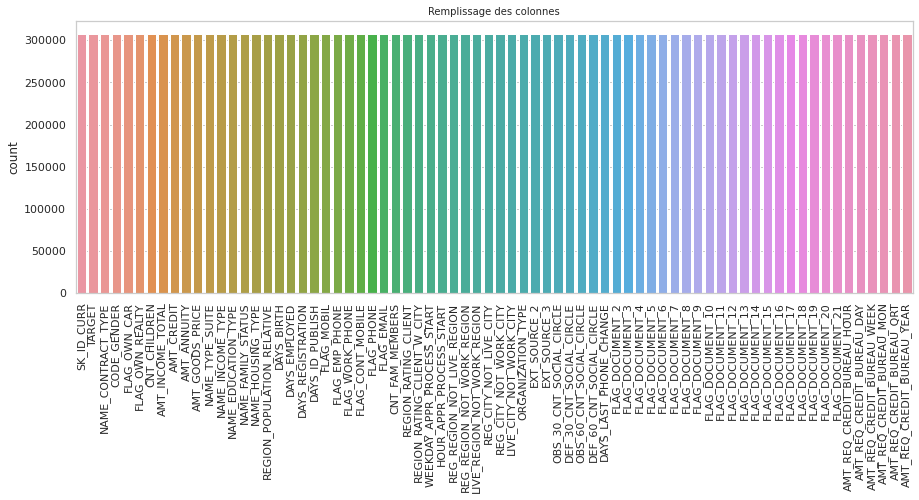

In [ ]:
## imputation des variables numérique
data_work_train = data_work_train.fillna(data_work_train.mean())
col_filling(data_work_train, head=5)

In [ ]:
## exportation du data 
data_work_train.to_csv (path+"data_clean.csv", index = False, header=True)

- ## Data enginering

In [ ]:
# Preprocess application_train.csv and application_test.csv
def data_eng(df, nan_as_category = True):
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
        # CODE_GENDER : 0=>M et 1=>F
        # FLAG_OWN_CAR : 0=>N et 1=>Y
        # FLAG_OWN_REALTY : 0=>Y et 1=>N
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category = nan_as_category)

    """En parcourant les forums de discussion, on constate que la valeur 365 243 représente les cas où l'information n'est 
    pas fournie, c'est-à-dire que le candidat n'était pas employé. """
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']# taux du montant du revenu par rapport au montant du credit du client
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']# jours employé par rapport à l'âge du client
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS'] # part du revenu du client par rapport au membre de la famille 
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']# taux de la rente annuelle par rapport revenu global du client
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT'] # Taux de la rente annuelle par rapport au credit du client
    gc.collect()
    return df

In [ ]:
data_clean = pd.read_csv(path+'data_clean.csv')
print('data train clean',data_clean.shape)
data_clean_test = pd.read_csv(path+'data_clean_test.csv')
print('data test clean',data_clean_test.shape)

data train clean (307511, 72)
data test clean (48744, 71)


In [ ]:
data_enginering = data_eng(data_clean, nan_as_category = True)
print('data train enginering',data_enginering.shape)
data_enginering_test = data_eng(data_clean_test, nan_as_category = True)
print('data test enginering',data_enginering_test.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


data train enginering (307507, 176)
data test enginering (48744, 173)


In [ ]:
data_enginering.head(2)

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,...,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_nan,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.622246,0.510853,1.0,0.0,1.0,0.0,-828.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.070862,0.208736,135000.0,0.132217,0.027598


In [ ]:
get_NaN_col(data_enginering_test, limit=0.0)

['DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC']

PAYMENT_RATE                             0.0
ANNUITY_INCOME_PERC                      0.0
AMT_REQ_CREDIT_BUREAU_YEAR               0.0
AMT_REQ_CREDIT_BUREAU_QRT                0.0
AMT_REQ_CREDIT_BUREAU_MON                0.0
AMT_REQ_CREDIT_BUREAU_WEEK               0.0
AMT_REQ_CREDIT_BUREAU_DAY                0.0
AMT_REQ_CREDIT_BUREAU_HOUR               0.0
FLAG_DOCUMENT_21                         0.0
FLAG_DOCUMENT_20                         0.0
FLAG_DOCUMENT_19                         0.0
FLAG_DOCUMENT_18                         0.0
FLAG_DOCUMENT_17                         0.0
FLAG_DOCUMENT_16                         0.0
FLAG_DOCUMENT_15                         0.0
FLAG_DOCUMENT_14                         0.0
FLAG_DOCUMENT_13                         0.0
FLAG_DOCUMENT_12                         0.0
FLAG_DOCUMENT_11                         0.0
FLAG_DOCUMENT_10                         0.0
FLAG_DOCUMENT_9                          0.0
NAME_CONTRACT_TYPE_Cash loans            0.0
NAME_CONTR

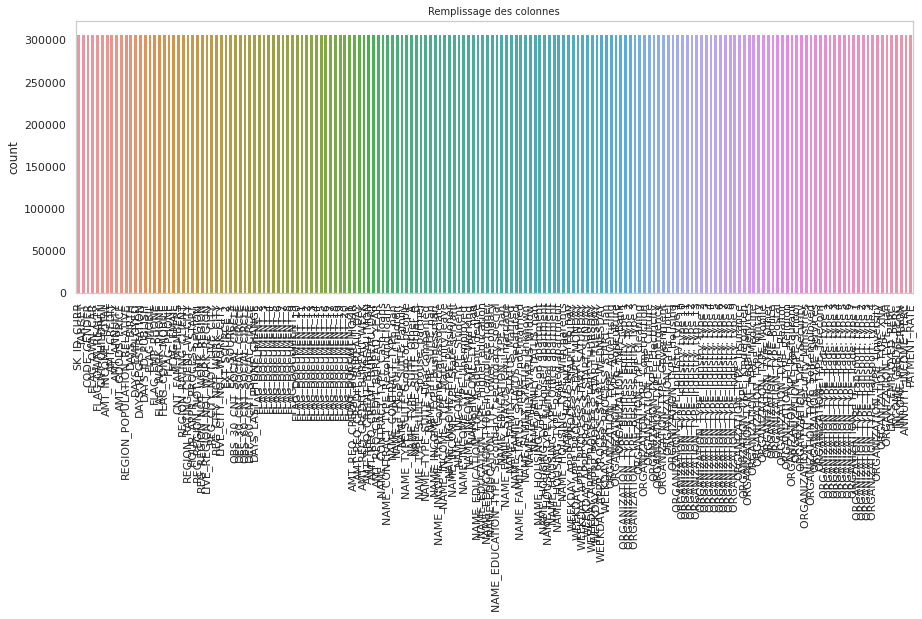

In [ ]:
## imputation des variables numérique
data_enginering = data_enginering.fillna(data_enginering.mean())
col_filling(data_enginering, head=1)

In [ ]:
## imputation des variables numérique
data_enginering_test = data_enginering_test.fillna(data_enginering_test.mean())

## exportation du data 
data_enginering_test.to_csv (path+"data_enginering_test.csv", index = False, header=True)

In [ ]:
## exportation du data 
data_enginering.to_csv (path+"data_enginering.csv", index = False, header=True)

- ## Sélection des variables

In [ ]:
data_select = pd.read_csv(path+'data_enginering.csv')
print(data_select.shape)

(307507, 176)


In [ ]:
data_select.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,...,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_nan,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.622246,0.510853,1.0,0.0,1.0,0.0,-828.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,0.650442,0.510853,2.0,0.0,2.0,0.0,-617.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,0.322738,0.510853,0.0,0.0,0.0,0.0,-1106.0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623


- Bien que la multicollinéarité n'affecte pas les performances du modèle, elle en affecte l'interprétabilité. Si nous ne supprimons pas la multicollinéarité, nous ne saurons jamais dans quelle mesure une variable contribue au résultat. Par conséquent, nous devons supprimer la multicollinéarité.

- ###### Détection de la multicollinéarité par VIF

- Le VIF est un nombre qui détermine si une variable présente une multicollinéarité ou non. Ce nombre représente également à quel point une variable est gonflée en raison de sa dépendance linéaire avec d'autres variables. Pour calculer le VIF, nous allons effectuer un processus de régression linéaire pour chaque variable, où cette variable deviendra une variable cible. Après avoir effectué ce processus, nous calculons le carré R à partir de celui-ci. Et enfin, nous calculons la valeur VIF avec cette formule : VIF = 1/(1-R²)

In [ ]:
data_select.columns[2:177]

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'ORGANIZATION_TYPE_Transport: type 3',
       'ORGANIZATION_TYPE_Transport: type 4', 'ORGANIZATION_TYPE_University',
       'ORGANIZATION_TYPE_XNA', 'ORGANIZATION_TYPE_nan', 'DAYS_EMPLOYED_PERC',
       'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC',
       'PAYMENT_RATE'],
      dtype='object', length=174)

In [ ]:
## detection de la multicolinéarité des variables avec VIF (variance_inflation_factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor 
X = data_select[list(data_select.columns[2:177])]
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])] 
vif_data.sort_values('VIF', ascending=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,feature,VIF
86,NAME_EDUCATION_TYPE_Secondary / secondary special,inf
79,NAME_INCOME_TYPE_Unemployed,inf
95,NAME_HOUSING_TYPE_Co-op apartment,inf
93,NAME_FAMILY_STATUS_Widow,inf
91,NAME_FAMILY_STATUS_Single / not married,inf
...,...,...
87,NAME_EDUCATION_TYPE_nan,NaN
94,NAME_FAMILY_STATUS_nan,NaN
101,NAME_HOUSING_TYPE_nan,NaN
109,WEEKDAY_APPR_PROCESS_START_nan,NaN


In [ ]:
## exportation du data 
vif_data.to_csv (path+"vif_data.csv", index = False, header=True)
print(vif_data.sort_values("VIF", ascending=False))

                                              feature       VIF
86  NAME_EDUCATION_TYPE_Secondary / secondary special       inf
79                        NAME_INCOME_TYPE_Unemployed       inf
95                  NAME_HOUSING_TYPE_Co-op apartment       inf
93                           NAME_FAMILY_STATUS_Widow       inf
91            NAME_FAMILY_STATUS_Single / not married       inf
..                                                ...       ...
36                                    FLAG_DOCUMENT_2  1.003524
38                                    FLAG_DOCUMENT_4  1.003515
13                                         FLAG_MOBIL  1.000900
46                                   FLAG_DOCUMENT_12  1.000733
44                                   FLAG_DOCUMENT_10  1.000619

[166 rows x 2 columns]


- Nous allons supprimer les variables de valeurs NaN et inf de VIF

In [ ]:
## suppression des NaN vif
vif_data.dropna(axis=0, inplace=True)

## selction des var sans NaN vif
No_Nan_val = list(vif_data['feature'].values)
index_target = ['SK_ID_CURR',	'TARGET']
all_col = index_target + No_Nan_val
all_col


['SK_ID_CURR',
 'TARGET',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'F

In [ ]:
data_select = data_select[all_col]
#data_select.head()

In [ ]:
#vif_data[vif_data['VIF'] == inf]
#vif_data[vif_data['VIF'] == inf]['feature'].values
del_col_vif = list(vif_data[vif_data['VIF'] == inf]['feature'].values)
#del_col_vif

- Nous allons supprimmer également les variables qui ont des valeurs VIF supérieur à 4.6

In [ ]:
## selection suppression des variables multicollinéaire
del_col_vif2 = list(vif_data[vif_data['VIF'] > 4.6]['feature'].values)
#data_colinea1 = vif_data[vif_data['VIF']> 4.6]
#var_colinea1 = list(data_colinea1['feature'].unique())
#var_colinea1

In [ ]:
del_col = del_col_vif + del_col_vif2
del_col

['CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'NAME_CONTRACT_TYPE_Cash loans',
 'NAME_CONTRACT_TYPE_Revolving loans',
 'NAME_TYPE_SUITE_Children',
 'NAME_TYPE_SUITE_Family',
 'NAME_TYPE_SUITE_Group of people',
 'NAME_TYPE_SUITE_Other_A',
 'NAME_TYPE_SUITE_Other_B',
 'NAME_TYPE_SUITE_Spouse, partner',
 'NAME_TYPE_SUITE_Unaccompanied',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Student',
 'NAME_INCOME_TYPE_Unemployed',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Academic degree',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_FAMILY_STATUS_Civil marriage',
 'NAME_FAMILY_STATUS_Married',
 'NAME_FAMILY_STATUS_Separated',
 'NAME_FAMILY_STATUS_Single / not married',
 'NAME_FAMILY_STATUS_Widow',
 'NAME_HOUSING_TYPE_Co-op apartment',
 'NAME_HOUSING_TYPE_House / apartment',
 'NA

In [ ]:
## suppression des valeurs de vif infinie
data_select = data_select.drop(del_col, axis=1)
data_select.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,EXT_SOURCE_2,EXT_SOURCE_3,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_7,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1,0,0,0,0.018801,-9461,-3648.0,-2120,1,0,1,1,0,10,0,0,0.262949,0.139376,2.0,2.0,-1134.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000,0.121978,0.060749
1,100003,0,1,0,1,0.003541,-16765,-1186.0,-291,1,0,1,1,0,11,0,0,0.622246,0.510853,0.0,0.0,-828.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.132217,0.027598
2,100004,0,0,1,0,0.010032,-19046,-4260.0,-2531,1,1,1,1,0,9,0,0,0.555912,0.729567,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.100000,0.050000
3,100006,0,1,0,0,0.008019,-19005,-9833.0,-2437,1,0,1,0,0,17,0,0,0.650442,0.510853,0.0,0.0,-617.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974,0.219900,0.094941
4,100007,0,0,0,0,0.028663,-19932,-4311.0,-3458,1,0,1,0,0,11,0,0,0.322738,0.510853,0.0,0.0,-1106.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.179963,0.042623


In [ ]:
data_select.columns

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4',
       'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
      

In [ ]:
data_select.shape

(307507, 47)

In [ ]:
print("Description",HomeCredit_columns_description[HomeCredit_columns_description['Row']=="FLAG_DOCUMENT_2"]["Description"])


Description 99    Did client provide document 2
Name: Description, dtype: object


In [ ]:
## exportation du data 
data_select.to_csv (path+"data_select_vif.csv", index = False, header=True)

In [ ]:
## chargement
data_select = pd.read_csv(path+'data_select_vif.csv')
print(data_select.shape)

(307507, 47)


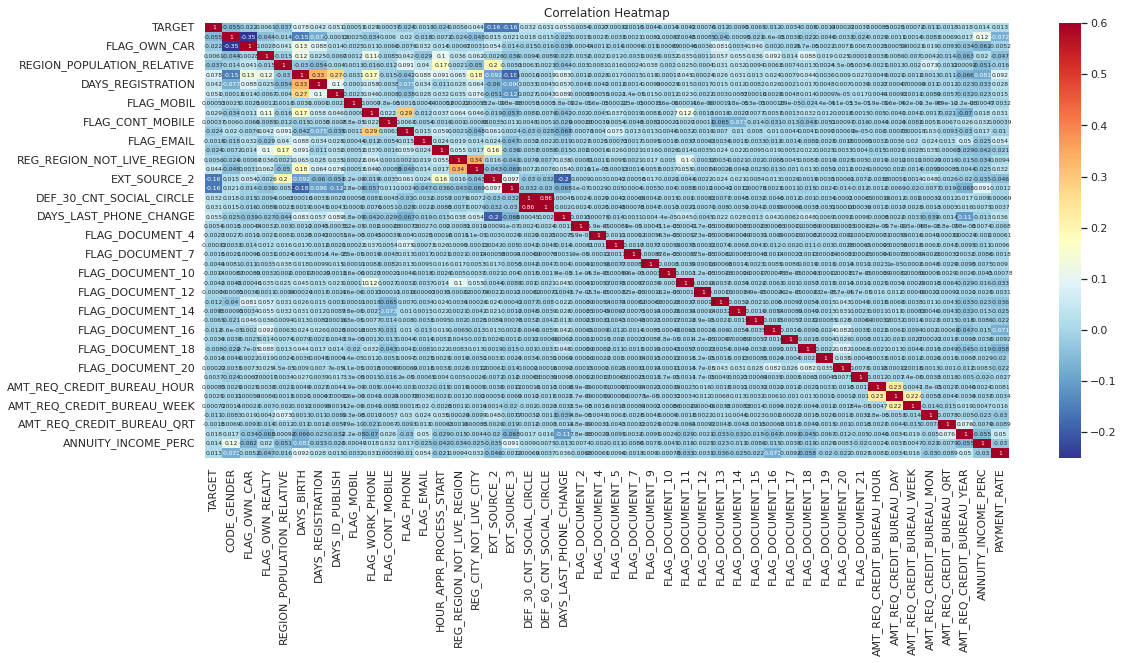

In [ ]:
data_final = data_select.set_index('SK_ID_CURR')
ext_data_corrs = data_final.corr()
plt.figure(figsize = (18, 8))
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [ ]:
data_final.to_csv(path+'data_final_select_vif.csv', index=True, header=True)

- ###### Exploration

In [ ]:
df_final = pd.read_csv(path+'data_final_select_vif.csv')
df_final = df_final.set_index('SK_ID_CURR')
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 100002 to 456255
Data columns (total 46 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   TARGET                      307507 non-null  int64  
 1   CODE_GENDER                 307507 non-null  int64  
 2   FLAG_OWN_CAR                307507 non-null  int64  
 3   FLAG_OWN_REALTY             307507 non-null  int64  
 4   REGION_POPULATION_RELATIVE  307507 non-null  float64
 5   DAYS_BIRTH                  307507 non-null  int64  
 6   DAYS_REGISTRATION           307507 non-null  float64
 7   DAYS_ID_PUBLISH             307507 non-null  int64  
 8   FLAG_MOBIL                  307507 non-null  int64  
 9   FLAG_WORK_PHONE             307507 non-null  int64  
 10  FLAG_CONT_MOBILE            307507 non-null  int64  
 11  FLAG_PHONE                  307507 non-null  int64  
 12  FLAG_EMAIL                  307507 non-null  int64  
 13  HOUR_APPR

Text(0.5, 1.0, 'EXT_SOURCE_3')

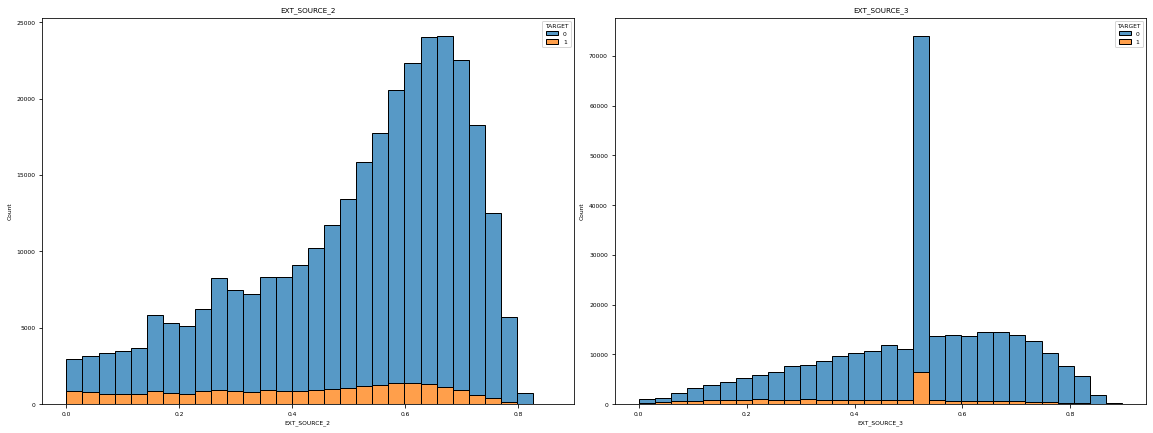

In [ ]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16, 6))
sns.histplot(data=df_final,x='EXT_SOURCE_2', ax=axs[0], bins=30, hue='TARGET', multiple="stack")

sns.histplot(data=df_final, x='EXT_SOURCE_3', ax=axs[1], bins=30, hue='TARGET', multiple="stack")
axs[0].set_title('EXT_SOURCE_2')
axs[1].set_title('EXT_SOURCE_3')

Text(0.5, 1.0, 'DAYS_LAST_PHONE_CHANGE')

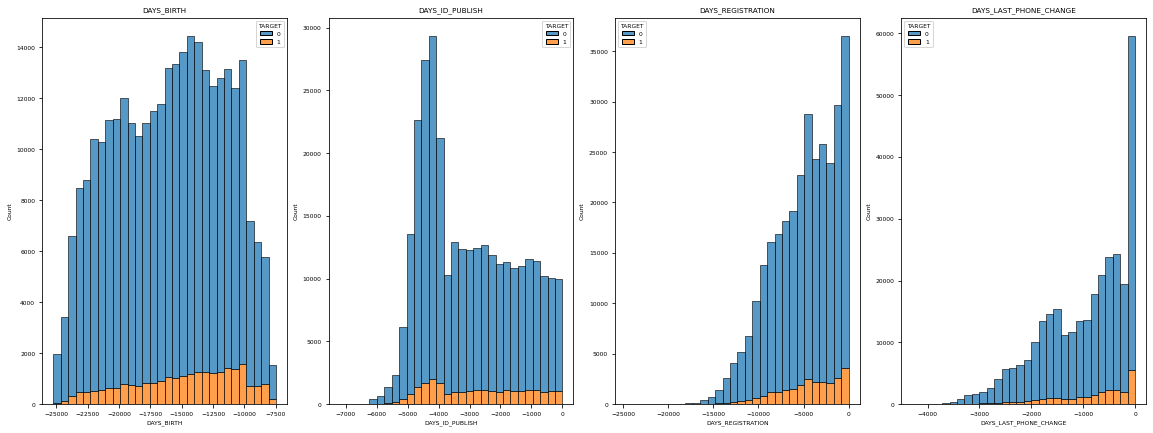

In [ ]:
fig, axs = plt.subplots(1, 4, tight_layout=True, figsize=(16, 6))
sns.histplot(data=df_final,x='DAYS_BIRTH', ax=axs[0], bins=30, hue='TARGET', multiple="stack")
sns.histplot(data=df_final, x='DAYS_ID_PUBLISH', ax=axs[1], bins=30, hue='TARGET', multiple="stack")
sns.histplot(data=df_final, x='DAYS_REGISTRATION', ax=axs[2], bins=30, hue='TARGET', multiple="stack")
sns.histplot(data=df_final, x='DAYS_LAST_PHONE_CHANGE', ax=axs[3], bins=30, hue='TARGET', multiple="stack")
axs[0].set_title('DAYS_BIRTH')
axs[1].set_title('DAYS_ID_PUBLISH')
axs[2].set_title('DAYS_REGISTRATION')
axs[3].set_title('DAYS_LAST_PHONE_CHANGE')

Text(0.5, 1.0, 'PAYMENT_RATE')

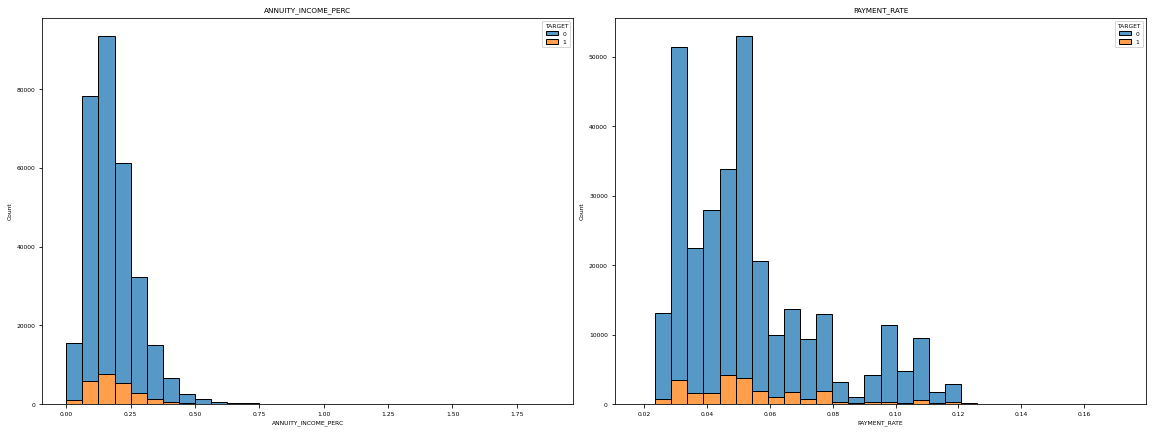

In [ ]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16, 6))
sns.histplot(data=df_final,x='ANNUITY_INCOME_PERC', ax=axs[0], bins=30, hue='TARGET', multiple="stack")
sns.histplot(data=df_final, x='PAYMENT_RATE', ax=axs[1], bins=30, hue='TARGET', multiple="stack")
axs[0].set_title('ANNUITY_INCOME_PERC')
axs[1].set_title('PAYMENT_RATE')


In [ ]:
# les observations dans chaque catégorie
#categ_plot(df_final, hue='TARGET')

In [ ]:
# répartition des variables numériques
#var_plot(df_final, hue='TARGET', vartypes="int64", kind="kde")

In [ ]:
# répartition des variables numériques
#var_plot(data_final, hue='TARGET', vartypes="float64", kind="hist")

In [ ]:
## exportation du data 
#df_final.to_csv (path+"extract_data.csv", index = True, header=True)

- ## Modélisation

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, fbeta_score, auc, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline 
from joblib import load,dump
from sklearn import set_config
# Setting of plot : 
set_config(display="diagram")
sns.set_style("whitegrid")
font_title = {"family": "serif", "color":  "#476bff", "weight": "bold", "size": 18}

In [6]:
#data_model = pd.read_csv(path+'data_final_select1.csv')
data_model = pd.read_csv(path+'data_final_select_vif.csv')
#data_model = data_model.set_index('SK_ID_CURR')
print("Shape of data",data_model.shape)
data_model.head()

Shape of data (307507, 47)


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,EXT_SOURCE_2,EXT_SOURCE_3,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_7,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1,0,0,0,0.018801,-9461,-3648.0,-2120,1,0,1,1,0,10,0,0,0.262949,0.139376,2.0,2.0,-1134.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000,0.121978,0.060749
1,100003,0,1,0,1,0.003541,-16765,-1186.0,-291,1,0,1,1,0,11,0,0,0.622246,0.510853,0.0,0.0,-828.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.132217,0.027598
2,100004,0,0,1,0,0.010032,-19046,-4260.0,-2531,1,1,1,1,0,9,0,0,0.555912,0.729567,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.100000,0.050000
3,100006,0,1,0,0,0.008019,-19005,-9833.0,-2437,1,0,1,0,0,17,0,0,0.650442,0.510853,0.0,0.0,-617.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974,0.219900,0.094941
4,100007,0,0,0,0,0.028663,-19932,-4311.0,-3458,1,0,1,0,0,11,0,0,0.322738,0.510853,0.0,0.0,-1106.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.179963,0.042623


In [7]:
def my_cost_func(y_test, y_pred):

    ''' 
    Customer cost function 
    '''
    cm = confusion_matrix(y_test, y_pred)
    score=(((10*cm[1,0]) + cm[0, 1])/cm.sum())
    return score

## Customer cost function metric
custom_score= make_scorer(my_cost_func, greater_is_better=False)

In [8]:
  # construire la courbe ROC
def build_ROC(y_test, y_predict, export_name='', title='ROC Curve'):
    fpr, tpr, thr = roc_curve(y_test, y_predict)
    aucs = auc(fpr, tpr)
    fig = plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, '-', lw=2, label='gamma=0.01, AUC=%.2f' % aucs)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title(title, fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.savefig(path+export_name+'ROC.png', bbox_inches='tight')
    plt.show()

In [9]:
def print_score(classifier, X_train, y_train, X_test, y_test, train=True):
    '''
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    if train:
        '''
        training performance
        '''
        print("Train Result:\n")
        print("classification_report: \n {}\n".format(classification_report(y_train, classifier.predict(X_train)))) ## matrice de confusion
        print("Cost function: \n {}\n".format(my_cost_func(y_train, classifier.predict(X_train))))
        build_ROC(y_train, classifier.predict(X_train), export_name='train_', title='ROC Curve')
        
    elif train==False:
        '''
        test performance
        '''
        print("Test Result:\n")        
        print("classification_report: \n {}\n".format(classification_report(y_test, classifier.predict(X_test))))
        print("Cost function: \n {}\n".format(my_cost_func(y_test, classifier.predict(X_test))))
        build_ROC(y_test, classifier.predict(X_test), export_name='train_', title='ROC Curve')

- ##### Echantillonnage

In [10]:
data_model.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,EXT_SOURCE_2,EXT_SOURCE_3,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_7,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1,0,0,0,0.018801,-9461,-3648.0,-2120,1,0,1,1,0,10,0,0,0.262949,0.139376,2.0,2.0,-1134.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000,0.121978,0.060749
1,100003,0,1,0,1,0.003541,-16765,-1186.0,-291,1,0,1,1,0,11,0,0,0.622246,0.510853,0.0,0.0,-828.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.132217,0.027598
2,100004,0,0,1,0,0.010032,-19046,-4260.0,-2531,1,1,1,1,0,9,0,0,0.555912,0.729567,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.100000,0.050000
3,100006,0,1,0,0,0.008019,-19005,-9833.0,-2437,1,0,1,0,0,17,0,0,0.650442,0.510853,0.0,0.0,-617.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974,0.219900,0.094941
4,100007,0,0,0,0,0.028663,-19932,-4311.0,-3458,1,0,1,0,0,11,0,0,0.322738,0.510853,0.0,0.0,-1106.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.179963,0.042623


In [11]:
## echantillon
X_train, X_test, y_train, y_test = train_test_split(data_model.drop('TARGET', axis=1), data_model['TARGET'].values, test_size = 0.3, random_state = 0)
## standardisation
cols = ['DAYS_BIRTH','DAYS_REGISTRATION','DAYS_ID_PUBLISH','HOUR_APPR_PROCESS_START','DAYS_LAST_PHONE_CHANGE']
std_scale = MinMaxScaler()
X_train[cols] = std_scale.fit_transform(X_train[cols])
X_test[cols] = std_scale.transform(X_test[cols])
y = pd.DataFrame(y_train)
X_train=X_train.drop('SK_ID_CURR', axis=1)
X_test=X_test.drop('SK_ID_CURR', axis=1)

- ##### Modèles

In [12]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics
    '''Fonction d'évaluation des mesures de performance d'un modèle '''
    y_pred = model.predict(x_test) # prediction de l'échantillon test

    # Calcul des mesures accuracy, precision, recall, f1-score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)

    # Calcul de l'AUC (area under curve) l'air sous la courbe
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # affichage de la matrice de confusion
    cm = metrics.confusion_matrix(y_test, y_pred)

    print({'cm': cm, 'acc': np.mean(acc), 'prec': np.mean(prec), 'rec': np.mean(rec), 'f1': np.mean(f1), 'auc': np.mean(auc)})

    ax = sns.heatmap(cm, annot=True, cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Étiquettes de labels - La liste doit être en ordre alphabétique
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Afficher la visualisation de la Matrice de Confusion.
    plt.show()

    #return {'cm': cm, 'acc': np.mean(acc), 'prec': np.mean(prec), 'rec': np.mean(rec), 'f1': np.mean(f1), 'auc': np.mean(auc)}

##################################################################################################

def model_comp(X_app, y_app, X_valid, y_valid, classWeight=None):
    '''Fonction de comparaison des performences des modèles '''
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from lightgbm import LGBMClassifier
        
    clfs = []
    clfs.append(LogisticRegression(solver='sag', class_weight=classWeight).fit(X_app, y_app))
    clfs.append(RandomForestClassifier(class_weight=classWeight).fit(X_app, y_app))
    clfs.append(LGBMClassifier(class_weight=classWeight).fit(X_app, y_app))
    for classifier in clfs:
        print('----'*30)
        print(str(classifier))
        print('----'*30)
        eval_train = evaluate_model(classifier, X_app, y_app)
        print("model train evaluate:\n" ,eval_train)
        eval_test = evaluate_model(classifier, X_valid, y_valid)
        print("model test evaluate:\n" ,eval_test)

##################################################################################################

def top_model2(X_train, y_train, X_test, y_test, train=True, classWeight="balanced", titl = ""):
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from lightgbm import LGBMClassifier
    from sklearn import metrics
    
    model1 = LogisticRegression(solver='sag', class_weight= classWeight).fit(X_train, y_train)
    model2 = RandomForestClassifier(class_weight= classWeight).fit(X_train, y_train)
    model3 = LGBMClassifier(class_weight= classWeight).fit(X_train, y_train)

    '''
    train performance
    '''
    if train:
        accur1 = metrics.accuracy_score(y_train, model1.predict(X_train)) ##
        roc_auc1 = metrics.roc_auc_score(y_train, model1.predict(X_train)) ## 
        prec1 = metrics.precision_score(y_train, model1.predict(X_train))
        rec1 = metrics.recall_score(y_train, model1.predict(X_train))
        f1 = metrics.f1_score(y_train, model1.predict(X_train))
        cost_fun1 =my_cost_func(y_train, model1.predict(X_train))

        accur2 = metrics.accuracy_score(y_train, model2.predict(X_train)) ## 
        roc_auc2 = metrics.roc_auc_score(y_train, model2.predict(X_train)) ## 
        prec2 = metrics.precision_score(y_train, model2.predict(X_train))
        rec2 = metrics.recall_score(y_train, model2.predict(X_train))
        f2 = metrics.f1_score(y_train, model2.predict(X_train))
        cost_fun2 =my_cost_func(y_train, model2.predict(X_train))

        accur3 = metrics.accuracy_score(y_train, model3.predict(X_train)) ##
        roc_auc3 = metrics.roc_auc_score(y_train, model3.predict(X_train)) ## 
        prec3 = metrics.precision_score(y_train, model3.predict(X_train))
        rec3 = metrics.recall_score(y_train, model3.predict(X_train))
        f3 = metrics.f1_score(y_train, model3.predict(X_train))
        cost_fun3 =my_cost_func(y_train, model3.predict(X_train))

        tab_app = pd.DataFrame(data = [[accur1, roc_auc1, prec1, rec1, f1, cost_fun1],[accur2, roc_auc2, prec2, rec2, f2, cost_fun2],[accur3, roc_auc3, prec3, rec3, f3, cost_fun3]],
                                       columns = ['Accuracy score','Roc auc score','Precision', 'Recall', 'f1', 'customer function'], index = ['Logistic Regression','Random Forest Classifier','LGBM Classifier'])
    elif train==False:
        '''
        test performance
        '''
        accur1 = metrics.accuracy_score(y_test, model1.predict(X_test)) ##
        roc_auc1 = metrics.roc_auc_score(y_test, model1.predict(X_test)) ##
        prec1 = metrics.precision_score(y_test, model1.predict(X_test))
        rec1 = metrics.recall_score(y_test, model1.predict(X_test))
        f1 = metrics.f1_score(y_test, model1.predict(X_test))
        cost_fun1 =my_cost_func(y_test, model1.predict(X_test))

        accur2 = metrics.accuracy_score(y_test, model2.predict(X_test)) ##
        roc_auc2 = metrics.roc_auc_score(y_test, model2.predict(X_test)) ##
        prec2 = metrics.precision_score(y_test, model2.predict(X_test))
        rec2 = metrics.recall_score(y_test, model2.predict(X_test))
        f2 = metrics.f1_score(y_test, model2.predict(X_test))
        cost_fun2 =my_cost_func(y_test, model2.predict(X_test))

        accur3 = metrics.accuracy_score(y_test, model3.predict(X_test)) ##
        roc_auc3 = metrics.roc_auc_score(y_test, model3.predict(X_test)) ##
        prec3 = metrics.precision_score(y_test, model3.predict(X_test))
        rec3 = metrics.recall_score(y_test, model3.predict(X_test))
        f3 = metrics.f1_score(y_test, model3.predict(X_test))
        cost_fun3 =my_cost_func(y_test, model3.predict(X_test))

        tab_app = pd.DataFrame(data = [[accur1, roc_auc1, prec1, rec1, f1, cost_fun1],[accur2, roc_auc2, prec2, rec2, f2, cost_fun2],[accur3, roc_auc3, prec3, rec3, f3, cost_fun3]],
                                       columns = ['Accuracy score','Roc auc score','Precision', 'Recall', 'f1', 'customer function'], index = ['Logistic Regression','Random Forest Classifier','LGBM Classifier'])
    
    plt.figure(figsize=(12,5))
    g = sns.heatmap(tab_app,linewidths=.2, cmap="YlGnBu", annot=True, fmt=".3f")
    g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 14)
    g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 14)
    plt.title(titl)
    plt.show()
##################################################################################################

## comparaison des modeles (echantillon équilibré) par validation croisée
def top_model(X_train, y_train, classWeight= 'balanced', titl = ""):
    
    model1 = LogisticRegression(solver='saga', class_weight= classWeight).fit(X_train, y_train)
    model2 = RandomForestClassifier(class_weight= classWeight).fit(X_train, y_train)
    model3 = LGBMClassifier(class_weight= classWeight).fit(X_train, y_train)

    accur1 = cross_val_score(model1, X_train, y_train, cv=5, scoring='accuracy') ##
    maccur1 = np.mean(accur1)
    roc_auc1 = cross_val_score(model1, X_train, y_train, cv=5, scoring='roc_auc') #
    mroc_auc1 = np.mean(roc_auc1)
    prec1 = cross_val_score(model1, X_train, y_train, cv=5, scoring='precision') ##
    mprec1 = np.mean(prec1)
    rec1 = cross_val_score(model1, X_train, y_train, cv=5, scoring='recall') ## 
    mrec1 = np.mean(rec1)
    f1 = cross_val_score(model1, X_train, y_train, cv=5, scoring='f1')
    mf1 = np.mean(f1)
    cost_fun1 =cross_val_score(model1, X_train, y_train, cv=5,scoring= custom_score)
    mcost_fun1 = np.mean(cost_fun1)

    accur2 = cross_val_score(model2, X_train, y_train, cv=5, scoring='accuracy') ##
    maccur2 = np.mean(accur2)
    roc_auc2 = cross_val_score(model2, X_train, y_train, cv=5, scoring='roc_auc') ## 
    mroc_auc2 = np.mean(roc_auc2)
    prec2 = cross_val_score(model2, X_train, y_train, cv=5, scoring='precision') ## 
    mprec2 = np.mean(prec2)
    rec2 = cross_val_score(model2, X_train, y_train, cv=5, scoring='recall') ##
    mrec2 = np.mean(rec2)
    f2 = cross_val_score(model2, X_train, y_train, cv=5, scoring='f1')
    mf2 = np.mean(f2)
    cost_fun2 =cross_val_score(model2, X_train, y_train, cv=5,scoring= custom_score)
    mcost_fun2 = np.mean(cost_fun2)

    accur3 = cross_val_score(model3, X_train, y_train, cv=5, scoring='accuracy') ##
    maccur3 = np.mean(accur3)
    roc_auc3 = cross_val_score(model3, X_train, y_train, cv=5, scoring='roc_auc') ## 
    mroc_auc3 = np.mean(roc_auc3)
    prec3 = cross_val_score(model3, X_train, y_train, cv=5, scoring='precision') ##
    mprec3 = np.mean(prec3)
    rec3 = cross_val_score(model3, X_train, y_train, cv=5, scoring='recall') ##
    mrec3 = np.mean(rec3)
    f3 = cross_val_score(model3, X_train, y_train, cv=5, scoring='f1')
    mf3 = np.mean(f3)
    cost_fun3 =cross_val_score(model3, X_train, y_train, cv=5,scoring= custom_score)
    mcost_fun3 = np.mean(cost_fun3)

    tab_app = pd.DataFrame(data = [[maccur1, mroc_auc1, mprec1, mrec1, mf1, mcost_fun1],[maccur2, mroc_auc2, mprec2, mrec2, mf2, mcost_fun2],[maccur3, mroc_auc3, mprec3, mrec3, mf3, mcost_fun3]],
                                       columns = ['Accuracy score','Roc auc score','Precision', 'Recall', 'f1_score', 'customer function'], index = ['Logistic Regression','Random Forest Classifier','LGBM Classifier']) 
    plt.figure(figsize=(12,5))
    g = sns.heatmap(tab_app,linewidths=.2, cmap="YlGnBu", annot=True, fmt=".3f")
    g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 14)
    g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 14)
    plt.title(titl)
    plt.show()
    return tab_app 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


------------------------------------------------------------------------------------------------------------------------
LogisticRegression(solver='sag')
------------------------------------------------------------------------------------------------------------------------
{'cm': array([[197748,    114],
       [ 17303,     89]]), 'acc': 0.9190862887565387, 'prec': 0.43842364532019706, 'rec': 0.0051172953081876724, 'f1': 0.010116510372264848, 'auc': 0.7275714630662128}


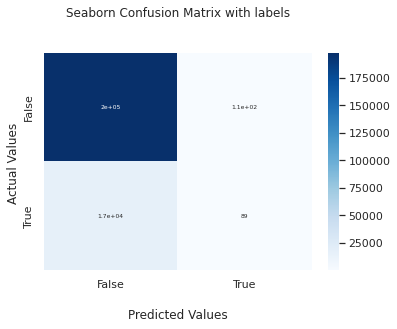

model train evaluate:
 None
{'cm': array([[84770,    50],
       [ 7402,    31]]), 'acc': 0.9192221391174271, 'prec': 0.38271604938271603, 'rec': 0.00417059060944437, 'f1': 0.008251264306627629, 'auc': 0.7331743723454799}


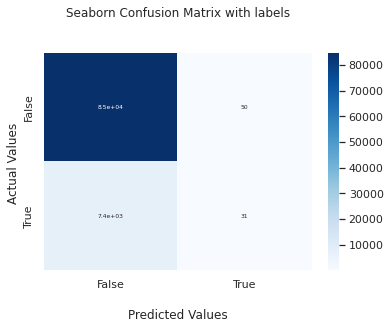

model test evaluate:
 None
------------------------------------------------------------------------------------------------------------------------
RandomForestClassifier()
------------------------------------------------------------------------------------------------------------------------
{'cm': array([[197862,      0],
       [     8,  17384]]), 'acc': 0.9999628346046996, 'prec': 1.0, 'rec': 0.999540018399264, 'f1': 0.9997699562916954, 'auc': 1.0}


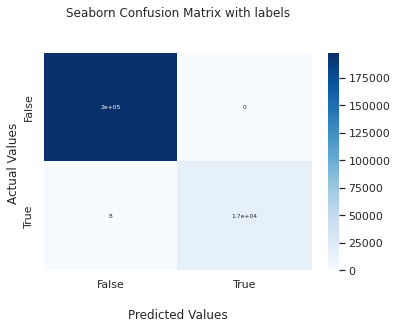

model train evaluate:
 None
{'cm': array([[84806,    14],
       [ 7422,    11]]), 'acc': 0.9193955752116463, 'prec': 0.44, 'rec': 0.0014798869904480022, 'f1': 0.0029498525073746317, 'auc': 0.7145690402921289}


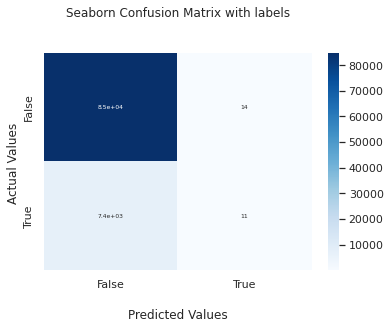

model test evaluate:
 None
------------------------------------------------------------------------------------------------------------------------
LGBMClassifier()
------------------------------------------------------------------------------------------------------------------------
{'cm': array([[197774,     88],
       [ 17123,    269]]), 'acc': 0.920043297685525, 'prec': 0.7535014005602241, 'rec': 0.01546688132474701, 'f1': 0.030311566848836555, 'auc': 0.7891772439628943}


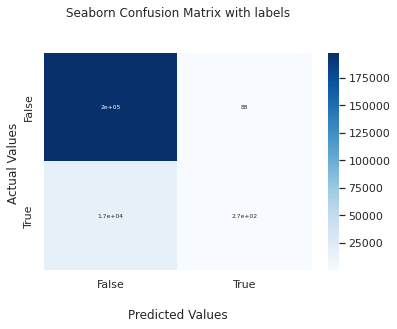

model train evaluate:
 None
{'cm': array([[84753,    67],
       [ 7361,    72]]), 'acc': 0.9194822932587559, 'prec': 0.5179856115107914, 'rec': 0.009686533028386924, 'f1': 0.01901743264659271, 'auc': 0.7525145136051993}


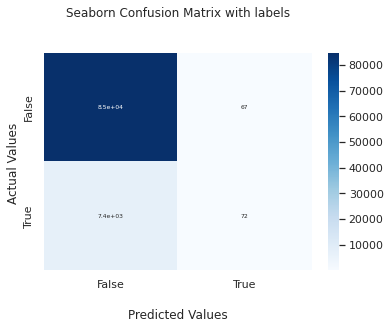

model test evaluate:
 None


In [ ]:
## Data Standard
model_comp(X_app=X_train, y_app=y_train, X_valid=X_test, y_valid=y_test, classWeight=None)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


------------------------------------------------------------------------------------------------------------------------
LogisticRegression(class_weight='balanced', solver='sag')
------------------------------------------------------------------------------------------------------------------------
{'cm': array([[134831,  63031],
       [  6025,  11367]]), 'acc': 0.6791883077666385, 'prec': 0.15278636522487163, 'rec': 0.6535763569457221, 'f1': 0.2476740385662926, 'auc': 0.7278210667016608}


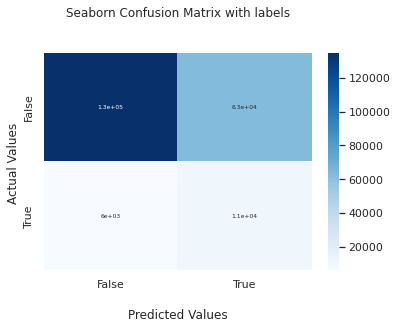

model train evaluate:
 None
{'cm': array([[57894, 26926],
       [ 2509,  4924]]), 'acc': 0.6809317854161925, 'prec': 0.15459968602825747, 'rec': 0.6624512309969057, 'f1': 0.25069368429091465, 'auc': 0.7332064945629356}


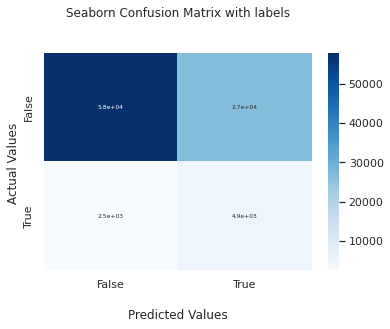

model test evaluate:
 None
------------------------------------------------------------------------------------------------------------------------
RandomForestClassifier(class_weight='balanced')
------------------------------------------------------------------------------------------------------------------------
{'cm': array([[197862,      0],
       [    12,  17380]]), 'acc': 0.9999442519070494, 'prec': 1.0, 'rec': 0.9993100275988961, 'f1': 0.9996548947428967, 'auc': 1.0}


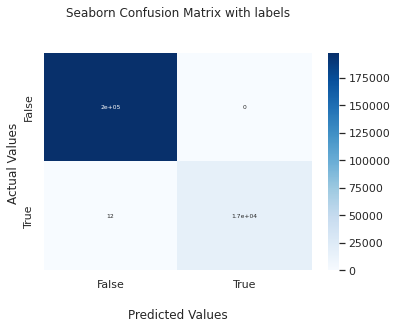

model train evaluate:
 None
{'cm': array([[84811,     9],
       [ 7429,     4]]), 'acc': 0.9193738956998688, 'prec': 0.3076923076923077, 'rec': 0.0005381407237992735, 'f1': 0.0010744023636852001, 'auc': 0.719678126403622}


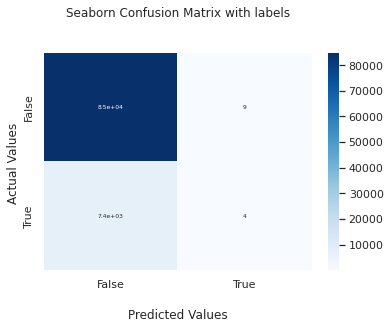

model test evaluate:
 None
------------------------------------------------------------------------------------------------------------------------
LGBMClassifier(class_weight='balanced')
------------------------------------------------------------------------------------------------------------------------
{'cm': array([[140008,  57854],
       [  4984,  12408]]), 'acc': 0.7080751112639022, 'prec': 0.17659616862599983, 'rec': 0.7134314627414904, 'f1': 0.2831131494284346, 'auc': 0.7863332730313919}


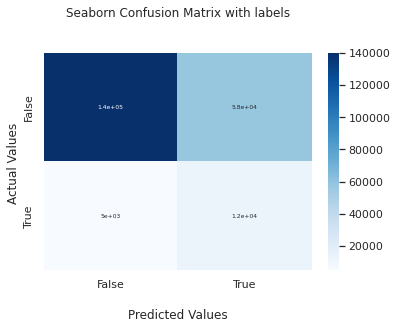

model train evaluate:
 None
{'cm': array([[59817, 25003],
       [ 2465,  4968]]), 'acc': 0.7022535852492602, 'prec': 0.1657602348937306, 'rec': 0.6683707789586977, 'f1': 0.2656400384985563, 'auc': 0.7524231892463977}


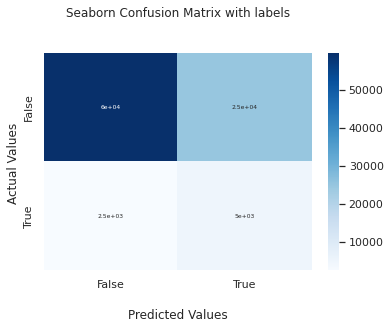

model test evaluate:
 None


In [ ]:
## Echantillon de donnée équilibrée
model_comp(X_app=X_train, y_app=y_train, X_valid=X_test, y_valid=y_test, classWeight='balanced')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


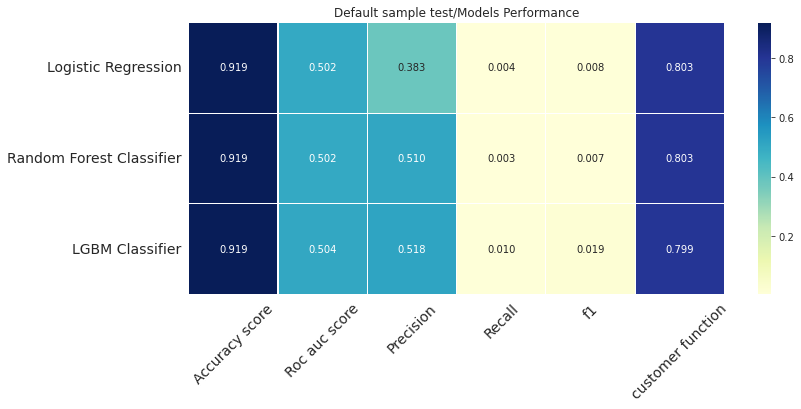

In [ ]:
## comparaison des modèles par train/test echantillon standard
#top_model2(X_train, y_train, X_test, y_test, train=True, classWeight=None, titl ="Default sample train/Models Performance" )
top_model2(X_train, y_train, X_test, y_test, train=False, classWeight=None, titl ="Default sample test/Models Performance" )

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


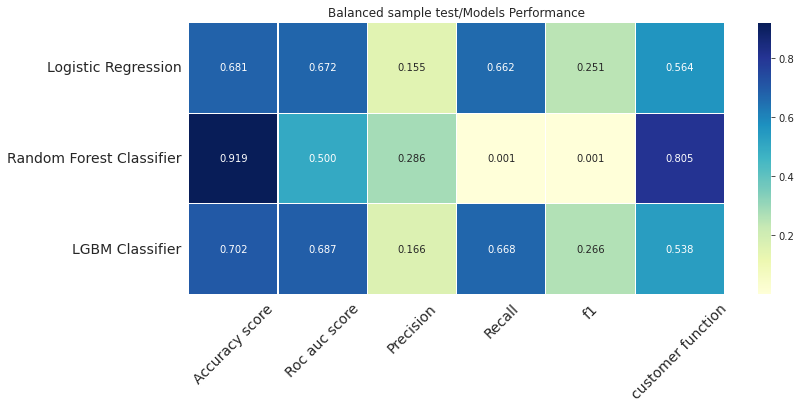

In [ ]:
## comparaison des modèles par train/test echantillon équilibré
top_model2(X_train, y_train, X_test, y_test, train=False, classWeight='balanced', titl ="Balanced sample test/Models Performance" )

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

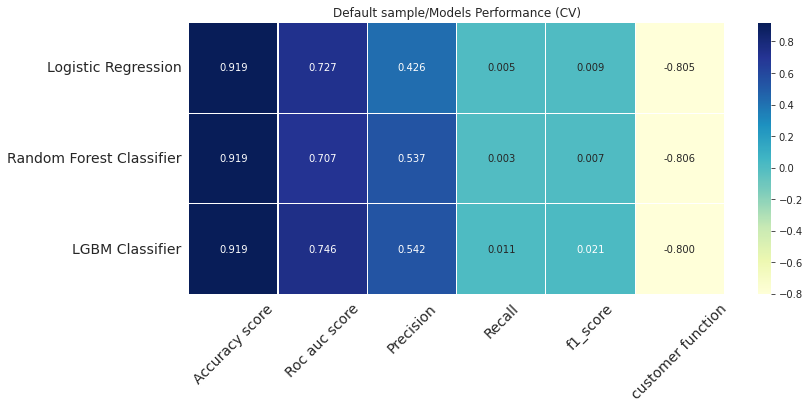

,Accuracy score,Roc auc score,Precision,Recall,f1_score,customer function
Logistic Regression,0.919054,0.726669,0.425910,0.004772,0.009435,-0.804654
Random Forest Classifier,0.919300,0.707458,0.536755,0.002587,0.006746,-0.805732
LGBM Classifier,0.919337,0.746332,0.541535,0.010867,0.021300,-0.799939


In [ ]:
## comparaison de modèles par validation croisée
comp_top_model = top_model(X_train, y_train, classWeight= None, titl = "Default sample/Models Performance (CV)")
comp_top_model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

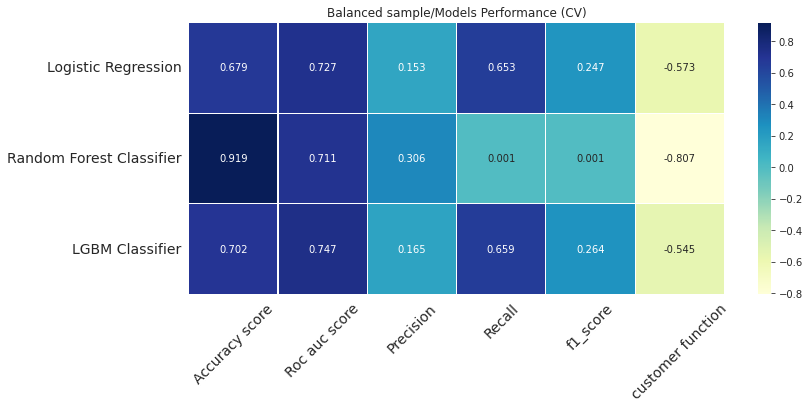

,Accuracy score,Roc auc score,Precision,Recall,f1_score,customer function
Logistic Regression,0.679295,0.726859,0.152705,0.652772,0.247488,-0.573211
Random Forest Classifier,0.919263,0.711153,0.306111,0.000920,0.001492,-0.807242
LGBM Classifier,0.702384,0.747434,0.164738,0.659326,0.263610,-0.545346


In [ ]:
## comparaison de modèles par validation croisée echantillon équilibré
comp_top_model = top_model(X_train, y_train, classWeight= 'balanced', titl = "Balanced sample/Models Performance (CV)")
comp_top_model

- ##### Optimisation

- ###### Logistic regression

In [ ]:
#### parameters distribution
param_distribs_log = {"C": np.linspace(0.05, 1, 5),
                      "penalty": ["l2"],#"l1", "l2", "elasticnet", "none"
                      "solver": ["newton-cg", "liblinear", "sag", "saga"]
                      }
log_model = LogisticRegression(class_weight="balanced")
GS_log_model = RandomizedSearchCV(log_model, param_distribs_log,  cv=5, scoring= custom_score, refit = True, n_jobs = 1,random_state=1)
GS_log_model.fit(X_train, y_train)
print("Best parameters {}".format(GS_log_model.best_params_))
print("Best score {:.4f}".format(GS_log_model.best_score_))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

Best parameters {'solver': 'sag', 'penalty': 'l2', 'C': 0.525}
Best score -0.5730


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
best_log_modele = LogisticRegression(**GS_log_model.best_params_)
best_log_modele.fit(X_train, y_train)
# enregistrement du modele
dump(best_log_modele, path+"best_model_log.joblib")
# chargement du modele
best_log_model = load(path+"best_model_log.joblib")
##### metrics
#print_score(best_log_modele, X_train, y_train, X_test, y_test, train=False)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


- ###### Random Forest

In [ ]:
#Random Forest
#### parameters distribution
param_distribs_rf = {
    'bootstrap': [True],
    'max_depth': [5, 10, 20],
    'n_estimators': [200,300,500],
    'max_features': ['auto', 'sqrt']}
rf_model = RandomForestClassifier(class_weight = "balanced", min_impurity_decrease= 0.0)
GS_rf_model = RandomizedSearchCV(rf_model, param_distribs_rf, cv=5, scoring= custom_score, refit = True, n_jobs = 1,random_state=1)
GS_rf_model.fit(X_train, y_train)
print("Best parameters {}".format(GS_rf_model.best_params_))
print("Best score {:.4f}".format(GS_rf_model.best_score_))

Best parameters {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
Best score -0.5618


In [ ]:
best_rf_modele = RandomForestClassifier(**GS_rf_model.best_params_ )
best_rf_modele.fit(X_train, y_train)
# enregistrement du modele
dump(best_rf_modele, path+"best_model_rf.joblib")
# chargement du modele
best_rf_model = load(path+"best_model_rf.joblib")

- ###### LightGBM Classifier

In [ ]:
## LGBM Classifier
#### parameters distribution
param_distribs_lgbm = {
        'n_estimators': [300, 500],
        'max_depth': [4, 5]
        }
lgbm_model = LGBMClassifier(class_weight = "balanced")
GS_lgbm = RandomizedSearchCV(lgbm_model, param_distribs_lgbm, cv=5, scoring= custom_score, refit = True, n_jobs = 1,random_state=1, verbose=1)
GS_lgbm.fit(X_train, y_train)
print("Best parameters {}".format(GS_lgbm.best_params_))
print("Best score {:.4f}".format(GS_lgbm.best_score_))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'n_estimators': 300, 'max_depth': 4}
Best score -0.5434


In [ ]:
best_lgbm_model = LGBMClassifier(**GS_lgbm.best_params_).fit(X_train, y_train)
#best_lgbm_model.fit(X_train, y_train)

#y_pred = best_lgbm_model.predict(X_test)
#print('Prediction : ', y_pred)
# enregistrement du modele
dump(best_lgbm_model, path+"best_model_lgbm.joblib")
# chargement du modele
best_lgbm_model = load(path+"best_model_lgbm.joblib")

## metrics
#print_score(best_lgbm_model, X_train, y_train, X_test, y_test, train=False)

- ### Choix du modele

In [ ]:
best_log_model = load(path+"best_model_log.joblib")
best_rf_model = load(path+"best_model_rf.joblib")
best_lgbm_model = load(path+"best_model_lgbm.joblib")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

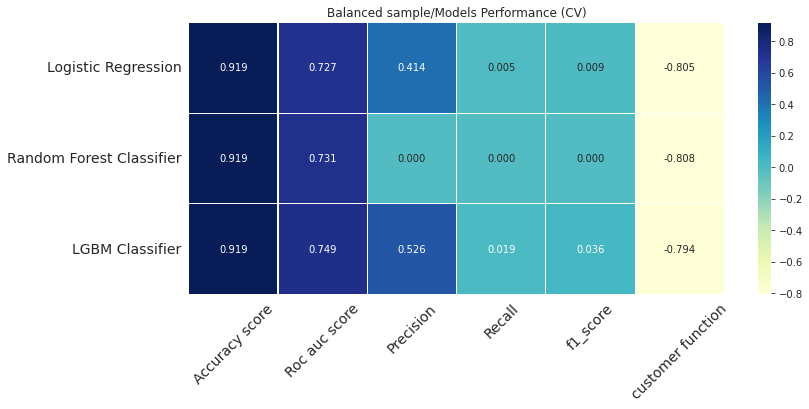

,Accuracy score,Roc auc score,Precision,Recall,f1_score,customer function
Logistic Regression,0.919035,0.726720,0.414468,0.004600,0.009095,-0.804798
Random Forest Classifier,0.919202,0.730593,0.000000,0.000000,0.000000,-0.807976
LGBM Classifier,0.919351,0.749497,0.526381,0.018514,0.035766,-0.794364


In [ ]:
## comparaison des modeles (echantillon équilibré) par validation croisée
def top_model(X_train, y_train, titl = ""):
    
    model1 = best_log_model
    model2 = best_rf_model
    model3 = best_lgbm_model

    accur1 = cross_val_score(model1, X_train, y_train, cv=5, scoring='accuracy') ##
    maccur1 = np.mean(accur1)
    roc_auc1 = cross_val_score(model1, X_train, y_train, cv=5, scoring='roc_auc') #
    mroc_auc1 = np.mean(roc_auc1)
    prec1 = cross_val_score(model1, X_train, y_train, cv=5, scoring='precision') ##
    mprec1 = np.mean(prec1)
    rec1 = cross_val_score(model1, X_train, y_train, cv=5, scoring='recall') ## 
    mrec1 = np.mean(rec1)
    f1 = cross_val_score(model1, X_train, y_train, cv=5, scoring='f1')
    mf1 = np.mean(f1)
    cost_fun1 =cross_val_score(model1, X_train, y_train, cv=5,scoring= custom_score)
    mcost_fun1 = np.mean(cost_fun1)

    accur2 = cross_val_score(model2, X_train, y_train, cv=5, scoring='accuracy') ##
    maccur2 = np.mean(accur2)
    roc_auc2 = cross_val_score(model2, X_train, y_train, cv=5, scoring='roc_auc') ## 
    mroc_auc2 = np.mean(roc_auc2)
    prec2 = cross_val_score(model2, X_train, y_train, cv=5, scoring='precision') ## 
    mprec2 = np.mean(prec2)
    rec2 = cross_val_score(model2, X_train, y_train, cv=5, scoring='recall') ##
    mrec2 = np.mean(rec2)
    f2 = cross_val_score(model2, X_train, y_train, cv=5, scoring='f1')
    mf2 = np.mean(f2)
    cost_fun2 =cross_val_score(model2, X_train, y_train, cv=5,scoring= custom_score)
    mcost_fun2 = np.mean(cost_fun2)

    accur3 = cross_val_score(model3, X_train, y_train, cv=5, scoring='accuracy') ##
    maccur3 = np.mean(accur3)
    roc_auc3 = cross_val_score(model3, X_train, y_train, cv=5, scoring='roc_auc') ## 
    mroc_auc3 = np.mean(roc_auc3)
    prec3 = cross_val_score(model3, X_train, y_train, cv=5, scoring='precision') ##
    mprec3 = np.mean(prec3)
    rec3 = cross_val_score(model3, X_train, y_train, cv=5, scoring='recall') ##
    mrec3 = np.mean(rec3)
    f3 = cross_val_score(model3, X_train, y_train, cv=5, scoring='f1')
    mf3 = np.mean(f3)
    cost_fun3 =cross_val_score(model3, X_train, y_train, cv=5,scoring= custom_score)
    mcost_fun3 = np.mean(cost_fun3)

    tab_app = pd.DataFrame(data = [[maccur1, mroc_auc1, mprec1, mrec1, mf1, mcost_fun1],[maccur2, mroc_auc2, mprec2, mrec2, mf2, mcost_fun2],[maccur3, mroc_auc3, mprec3, mrec3, mf3, mcost_fun3]],
                                       columns = ['Accuracy score','Roc auc score','Precision', 'Recall', 'f1_score', 'customer function'], index = ['Logistic Regression','Random Forest Classifier','LGBM Classifier']) 
    plt.figure(figsize=(12,5))
    g = sns.heatmap(tab_app,linewidths=.2, cmap="YlGnBu", annot=True, fmt=".3f")
    g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 14)
    g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 14)
    plt.title(titl)
    plt.show()
    return tab_app
compare_model = top_model(X_train, y_train, titl = "Balanced sample/Models Performance (CV)")
compare_model

In [ ]:
def print_score2(classifier, X_train, y_train, X_test, y_test, train=True):
    '''
    print the accuracy score, classification report and confusion matrix of classifier
    
    '''
    if train:
        '''
        training performance
        '''
        print("Train Result:\n")
        print("classification_report: \n {}\n".format(classification_report(y_train, classifier.predict(X_train)))) ## matrice de confusion
        print("Cost function: \n {}\n".format(my_cost_func(y_train, classifier.predict(X_train))))
        build_ROC(y_train, classifier.predict(X_train), export_name='train_', title='ROC Curve')
        
    elif train==False:
        '''
        test performance
        '''
        print("Test Result:\n")        
        print("classification_report: \n {}\n".format(classification_report(y_test, classifier.predict(X_test))))
        print("Cost function: \n {}\n".format(my_cost_func(y_test, classifier.predict(X_test))))
        build_ROC(y_test, classifier.predict(X_test), export_name='train_', title='ROC Curve')

In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 5.4 MB/s 


In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 5.0 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=85806ca5ba6727ec554b9e2758f315b723fd4b15cd230f8285a9b99cdee1f4a7
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
#!pip install shap
import shap

import lime

from lime import lime_tabular

 ============== Mesure de performance sur l'échantillon test ==============
Test Result:

classification_report: 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     84820
           1       0.52      0.02      0.04      7433

    accuracy                           0.92     92253
   macro avg       0.72      0.51      0.50     92253
weighted avg       0.89      0.92      0.88     92253


Cost function: 
 0.7924295144873338



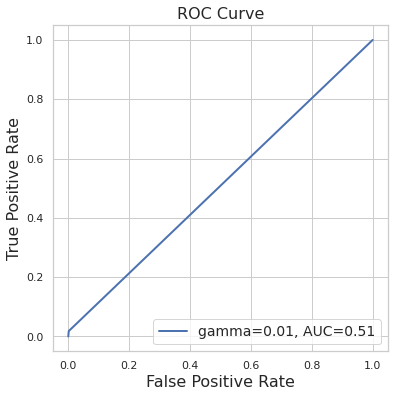

 ============== Mesure de performance par validation croisée ==============
Time :  44.23516130447388
fit_time  mean  5.519046624501546
score_time  mean  1.5864756107330322
test_accuracy  mean  0.9194114852928911
test_f1  mean  0.03685623310227571
test_roc_auc  mean  0.748321432661633
fit_time  mean  5.509718100229899
score_time  mean  0.7826291720072428
test_score  mean  -0.793885361516395


100%|===================| 215157/215254 [20:15<00:00]       

 ============== Impact global/shap des variables sur le modèles ==============


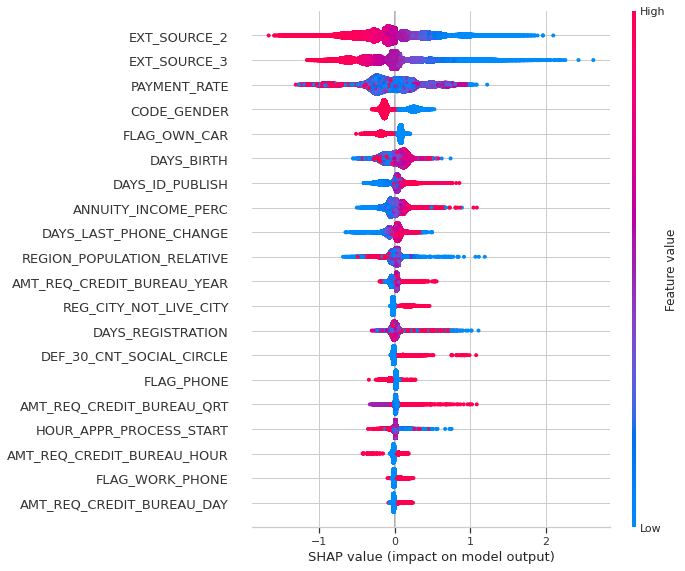

 ============== Impact local/shap des variables sur le modèles ==============


100%|===================| 215188/215254 [21:12<00:00]       

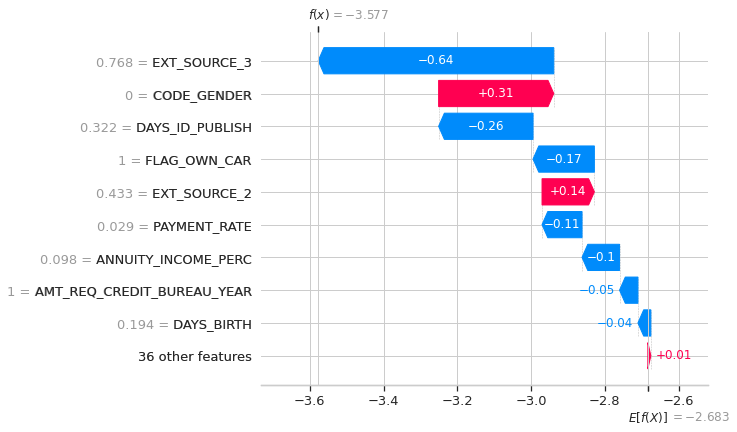

 ============== Impact local/lime des variables sur le modèles ==============
Intercept -0.02756632416856329
Prediction_local [0.06134878]
Right: 0.027195657104083896


In [ ]:
def main(X_app, y_app, X_valid, y_valid, num=0):
    ###### standardisation
    
    ###### modele
    #model = LGBMClassifier(n_estimators=1000 ,max_depth = 30, random_state=121, class_weight="balanced").fit(X_app, y_app)
    model = best_lgbm_model
    start = time.time()
    #print_score(model, X_app_std, y_app, X_valid_std, y_valid, train=True)
    print(" ============== Mesure de performance sur l'échantillon test ==============")
    print_score2(model, X_app, y_app, X_valid, y_valid, train=False)
    scores = cross_validate(model, X_app, y_app, cv=3, scoring=(['accuracy', 'f1', 'roc_auc']))
    score2 = cross_validate(model, X_app, y_app, cv=3,scoring= custom_score)
    end = time.time()
    print(" ============== Mesure de performance par validation croisée ==============")
    print("Time : ",end - start)
    #print('----'*30)
    for key, values in scores.items():
        print(key,' mean ', values.mean())
        #print(key,' std ', values.std())
    for key, values in score2.items():
        print(key,' mean ', values.mean())
    #print('----'*30)
    #build_ROC(y_valid, model.predict(X_valid), export_name='best_modele_', title='ROC Curve')
    #print('----'*30)
    ######################## SHAP ####################################
    shap_explainer = shap.Explainer(model, masker=X_app, feature_names=X_app.columns)
    shap_values = shap_explainer.shap_values(X_app)
    ## impact global des variables
    print(" ============== Impact global/shap des variables sur le modèles ==============")
    shap.summary_plot(shap_values, X_app, feature_names=X_app.columns)
    ## Impact des variables pour un client donné
    print(" ============== Impact local/shap des variables sur le modèles ==============")
    shap.plots.waterfall(shap_explainer(X_app)[num])#, max_display=12
    # Le diagramme de décision montre, comme le diagramme en cascade, le chemin de décision suivi 
    # en appliquant les valeurs shapées des caractéristiques individuelles une par une à la valeur attendue 
    # afin de générer une valeur prédite 
    # sous forme de graphique linéaire.
    ######################## LIME #####################################
    lime_explainer = lime_tabular.LimeTabularExplainer(X_app.to_numpy(), mode="classification", feature_names=X_app.columns,verbose=True)
    print(" ============== Impact local/lime des variables sur le modèles ==============")
    exp = lime_explainer.explain_instance(data_row=X_app.iloc[num], predict_fn=model.predict_proba)
    exp.show_in_notebook(show_table=True)

main(X_app=X_train, y_app=y_train, X_valid=X_test, y_valid=y_test, num=0)

In [ ]:
#X_train.to_csv(path+'X_train_vif.csv', index=False, header=True)
#y.to_csv(path+'y_train_vif.csv', index=False, header=True)
#X_test.to_csv(path+'X_test_vif.csv', index=False, header=True)

# Selection d'échantillon de 1000 client pour le dashboard
#data_model = pd.read_csv(path+'data_final_select_vif.csv')
#data_selectM = data_model.sample(n=1000)
#data_selectM["TARGET"]
#data_selectM.to_csv (path+"data_selectMille.csv", index = True, header=True)

# Selection de 100 échantillons test

#X_tr, X_tes, y_tr, y_tes = train_test_split(data_selectM.drop('TARGET', axis=1), data_selectM['TARGET'].values, test_size = 0.3, random_state = 0)
## standardisation
#cols = ['DAYS_BIRTH','DAYS_REGISTRATION','DAYS_ID_PUBLISH','HOUR_APPR_PROCESS_START','DAYS_LAST_PHONE_CHANGE']
#std_scale = MinMaxScaler()
#X_tr[cols] = std_scale.fit_transform(X_tr[cols])
#X_tes[cols] = std_scale.transform(X_tes[cols])
#X_tr.to_csv(path+'X_test_sample700.csv', index=False, header=True)
#253159